# **Exploratory Data Analysis**

In this notebook, we will analyze a dataset from a financial institution containing loan applicant information. ​Our primary objective is to develop a machine learning model capable of accurately predicting an applicant's likelihood of loan default.​ To accomplish this, we will follow these steps:

* Exploratory Data Analysis (EDA): We will thoroughly examine the data to uncover relationships between various variables and identify potential default predictors.

* Feature Engineering: Building on our EDA findings, we will create new features to enhance our machine learning model's performance.

The EDA in this notebook follows this logical progression:

1. Begin with a high-level overview, examining each dataset individually.

2. Delve deeper into:

    * How each feature can most significantly influence the default rate.
    * The distribution patterns of defaulters.
    * Further investigate potential new features that could improve predictive power.

To quantify the impact of features on default likelihood, we will calculate the Default Rate (DFR) for each variable.

In [3]:
from src.metadata import (application_metadata, bureau_bal_metadata, bureau_metada, cc_bal_metadata, inst_pmt_metadata, 
                      pos_cash_bal_metadata, prev_app_metadata, loans_config, reg_area_config)

from src.preprocessing import dataPipeline
from src.util import graphVisualizer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [9]:
pipeline = dataPipeline()

In [10]:
df_application = pipeline.importData('app')

In [12]:
df_prev_app = pipeline.importData('prev_app')

In [11]:
pkey = prev_app_metadata['primary_key'][0]
tg = application_metadata['target'][0]

Frequent visualizers are bundled within this `graphVisualizer` instance, it's easy to re-use and read

In [ ]:
g = graphVisualizer(df_application)

Note:
* Merge all active loan = calculate the current burden
* Has been DPD30/ 60 Flag
* Loan progress

Drop
* FLAG_MOBIL
* FLAG_EMP_PHONE
* FLAG_CONT_MOBILE

## **Application Data**

In [15]:
print(df_application.TARGET.sum()*100/df_application.shape[0])

8.659974537652149


### Personal Info

In [49]:
application_metadata['personal_info']

['DAYS_BIRTH', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']

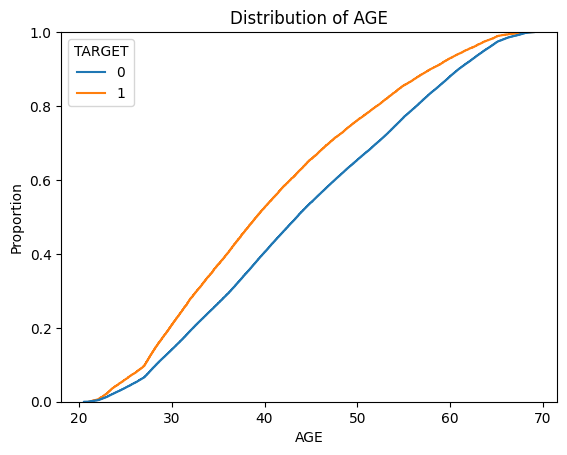

In [80]:
g.cdf('AGE', 'TARGET')

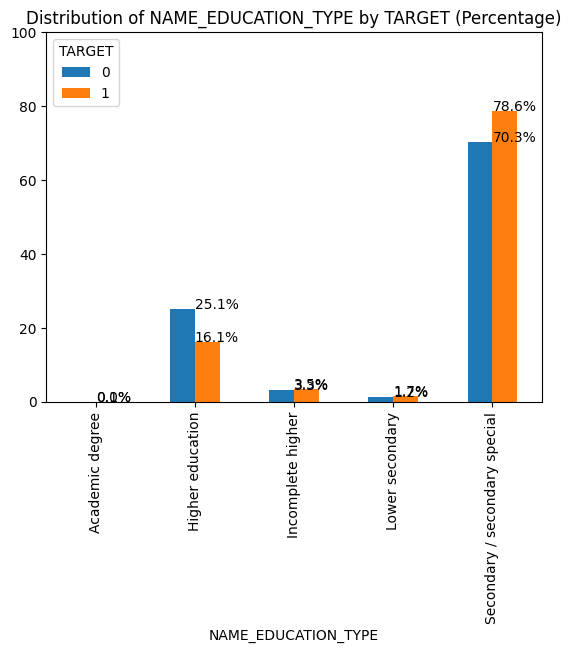

In [68]:
g.cat(index='NAME_EDUCATION_TYPE', columns='TARGET', values='SK_ID_CURR', aggfunc='count')

posx and posy should be finite values
posx and posy should be finite values


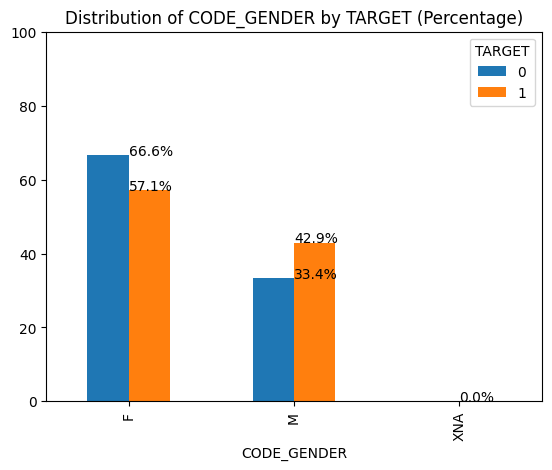

In [69]:
g.cat(index='CODE_GENDER', columns='TARGET', values='SK_ID_CURR', aggfunc='count')

### financial_info

Income
* OCCUPATION_TYPE
* NAME_INCOME_TYPE
* AMT_INCOME_TOTAL

Sense of security
* FLAG_OWN_REALTY
* DAYS_EMPLOYED
* ORGANIZATION_TYPE
* NAME_HOUSING_TYPE

In [50]:
application_metadata['financial_info']

['OCCUPATION_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'AMT_INCOME_TOTAL',
 'DAYS_EMPLOYED',
 'ORGANIZATION_TYPE',
 'NAME_HOUSING_TYPE',
 'OWN_CAR_AGE']

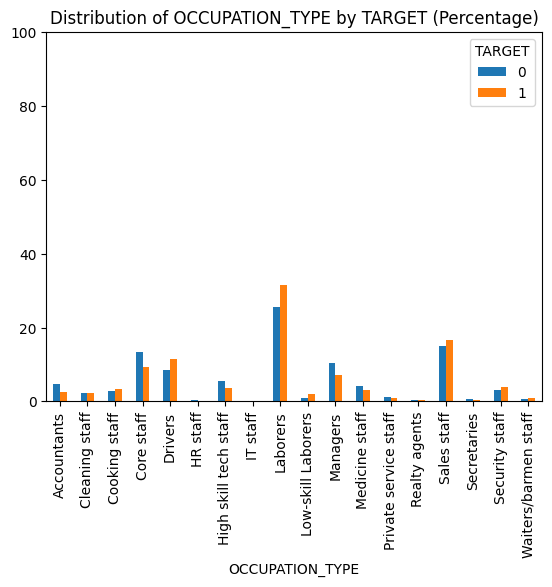

In [71]:
g.cat(index='OCCUPATION_TYPE', columns='TARGET', values='SK_ID_CURR', aggfunc='count', p_flag=False)

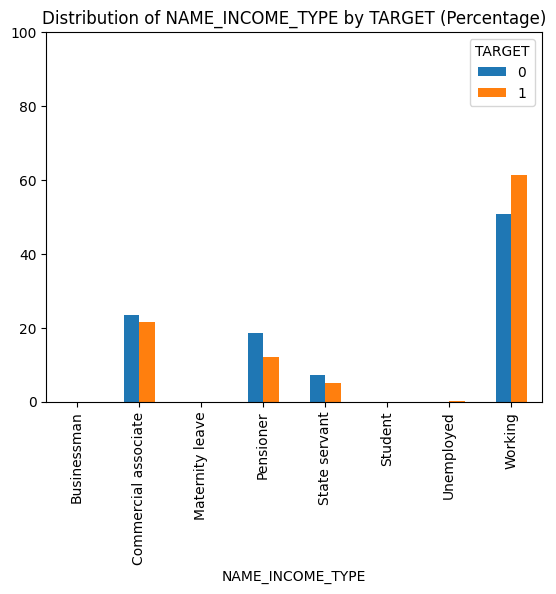

In [72]:
g.cat(index='NAME_INCOME_TYPE', columns='TARGET', values='SK_ID_CURR', aggfunc='count', p_flag=False)

In [13]:
df_application['P_INCOME_TOTAL'] = (round(df_application['AMT_INCOME_TOTAL'].rank(pct=True) * 100, 0)).astype(int)

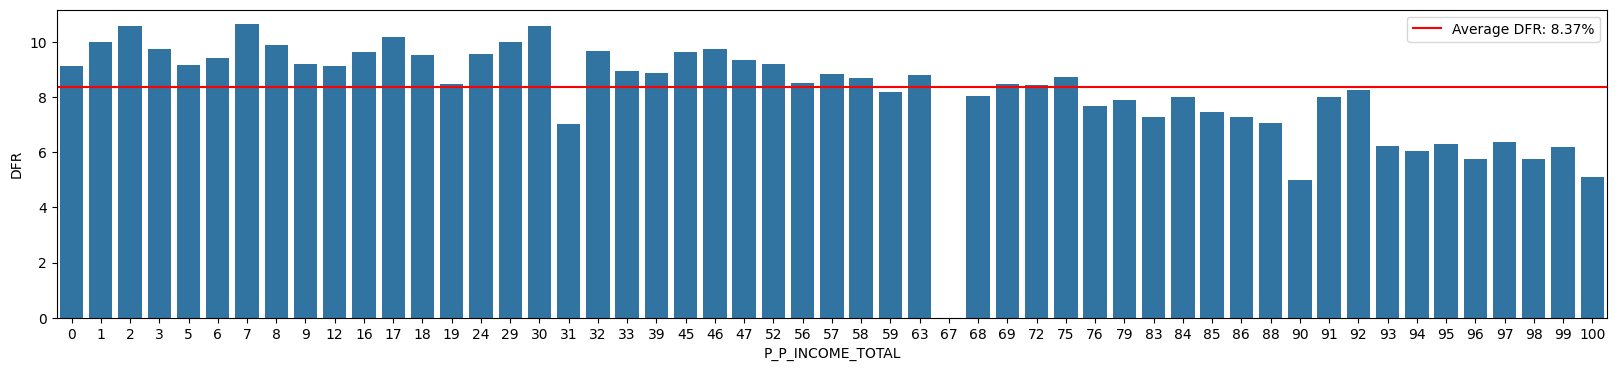

In [29]:
g.pctDfr('P_INCOME_TOTAL')

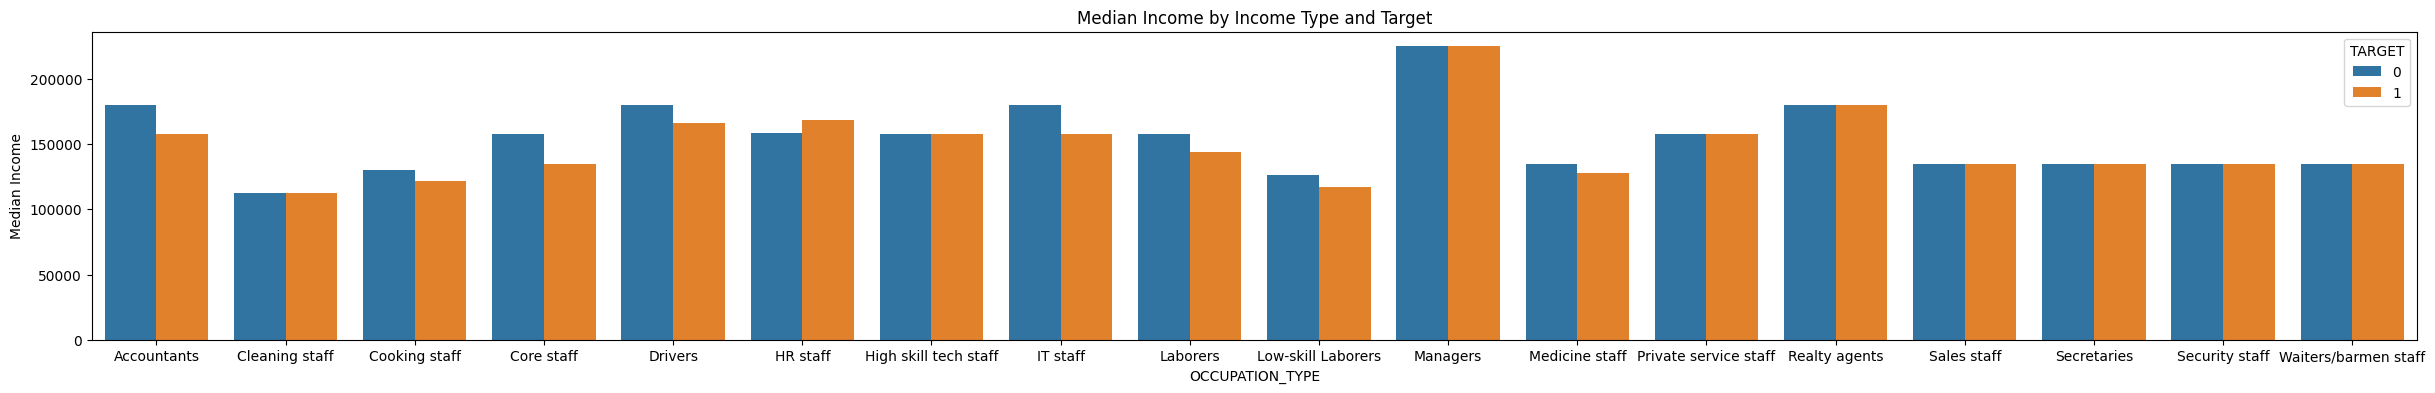

In [21]:
df_plot = df_application.groupby(['OCCUPATION_TYPE', 'TARGET'])[['AMT_INCOME_TOTAL']].median().reset_index()
df_unpivot = pd.melt(df_plot, id_vars=['OCCUPATION_TYPE', 'TARGET'], value_vars=['AMT_INCOME_TOTAL'])
df_unpivot = df_unpivot.rename(columns={'variable': 'Income Type', 'value': 'Median Income'})

plt.figure(figsize=(30,4))
sns.barplot(x='OCCUPATION_TYPE', y='Median Income', hue='TARGET', data=df_unpivot)
plt.title('Median Income by Income Type and Target')
plt.show()

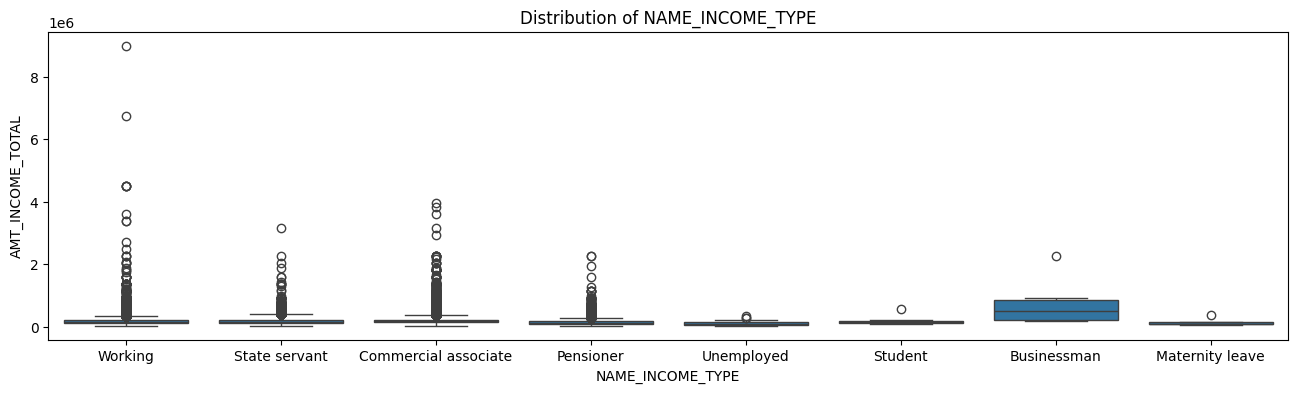

In [105]:
plt.figure(figsize=(16,4))
sns.boxplot(df_application[df_application['AMT_INCOME_TOTAL']< 1e7], x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL')
plt.title('Distribution of NAME_INCOME_TYPE')
plt.show()

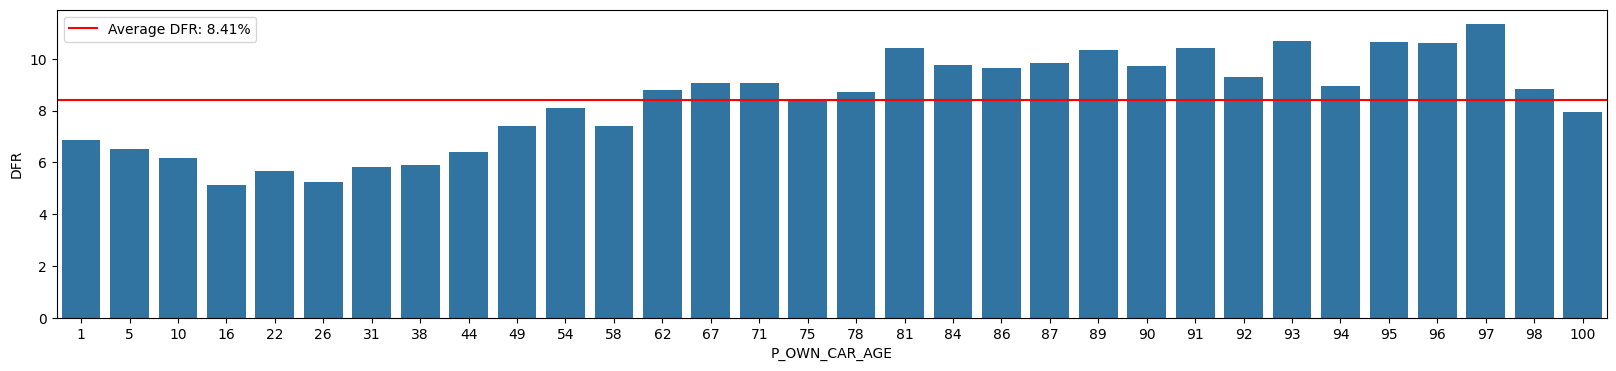

In [231]:
g.pctDfr('OWN_CAR_AGE', 'TARGET', 'SK_ID_CURR') #Null 60%

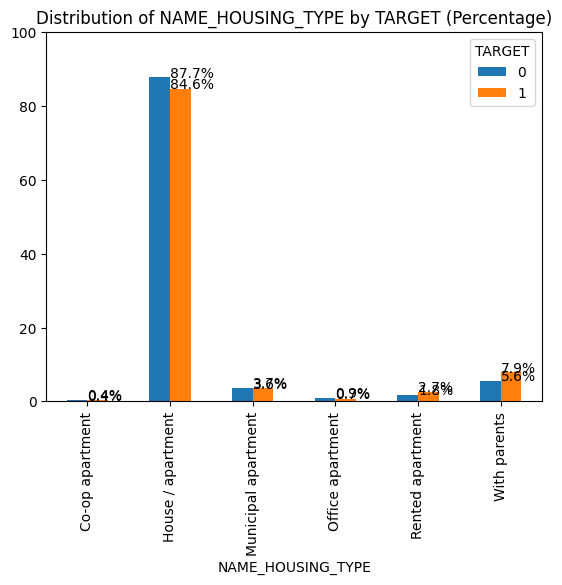

In [233]:
g.cat('NAME_HOUSING_TYPE', 'TARGET', 'SK_ID_CURR', 'count', True)

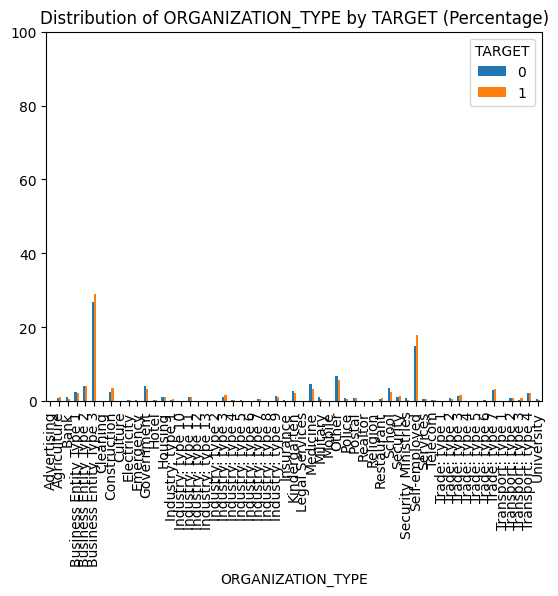

In [198]:
g.cat('ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR', aggfunc='count', p_flag=False)

## family_info

#### Psychologically

In [237]:
application_metadata['family_info']

['NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']

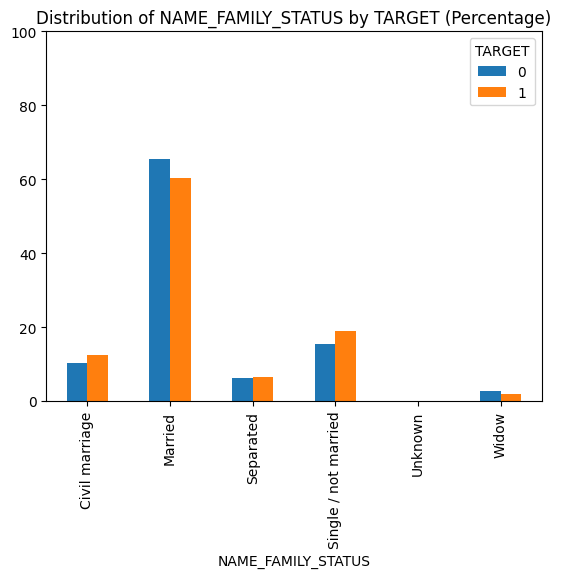

In [239]:
g.cat('NAME_FAMILY_STATUS', 'TARGET', 'SK_ID_CURR', aggfunc='count', p_flag=False)

In [241]:
df_application.groupby(['CNT_FAM_MEMBERS'])[['SK_ID_CURR']].count()

,SK_ID_CURR
CNT_FAM_MEMBERS,
1.0,49049
2.0,123330
3.0,51467
4.0,24360
5.0,3417
6.0,396
7.0,78
8.0,19
9.0,6


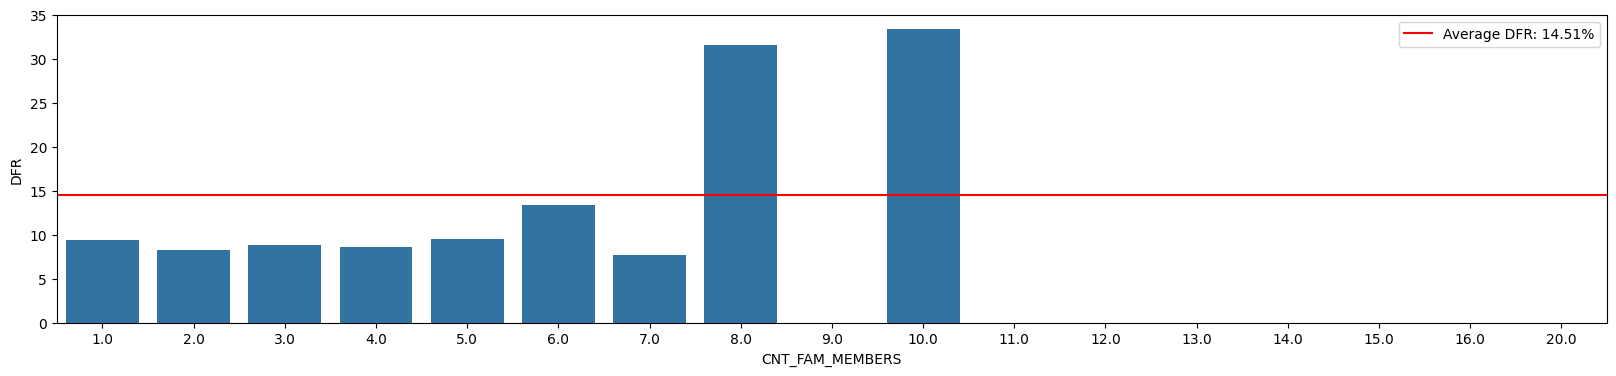

In [247]:
g.pctDfr('CNT_FAM_MEMBERS', 'TARGET', 'SK_ID_CURR', False)

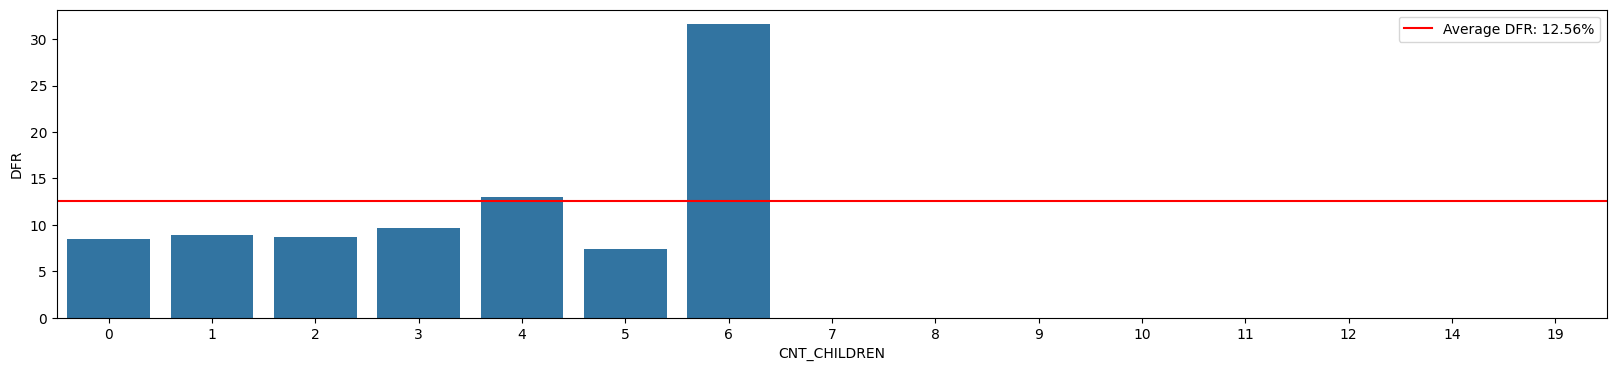

In [248]:
g.pctDfr('CNT_CHILDREN', 'TARGET', 'SK_ID_CURR', False)

Grouping family type

In [14]:
df_application['SPOUSE_CNT'] = df_application.NAME_FAMILY_STATUS.apply(lambda x: 1 if x in ['Civil marriage', 'Married'] else 0)
df_application['OTH_FAMILY_MEMBER'] = df_application['CNT_FAM_MEMBERS'] - df_application['CNT_CHILDREN'] - df_application['SPOUSE_CNT'] - 1 #self

In [15]:
df_application[df_application['NAME_FAMILY_STATUS'] == 'Separated'].groupby(['CNT_FAM_MEMBERS','CNT_CHILDREN'])[['SK_ID_CURR']].count()

,,SK_ID_CURR
CNT_FAM_MEMBERS,CNT_CHILDREN,
1.0,0,14132
2.0,1,4389
3.0,2,1111
4.0,3,122
5.0,4,12
6.0,5,2
7.0,6,1
15.0,14,1


In [16]:
df_application.groupby(['CNT_FAM_MEMBERS', 'CNT_CHILDREN'])[['SK_ID_CURR']].count()

SK_ID_CURR
CNT_FAM_MEMBERS CNT_CHILDREN            
1.0             0                  67847
2.0             0                 147522
                1                  10835
3.0             1                  50284
                2                   2317
4.0             2                  24432
                3                    265
5.0             3                   3452
                4                     26
6.0             4                    403
                5                      5
7.0             5                     79
                6                      2
8.0             6                     19
                7                      1
9.0             7                      6
10.0            8                      2
                9                      1
11.0            9                      1
12.0            10                     2
13.0            11                     1
14.0            12                     2
15.0            14                     1
16.0            14                     2
20.0            19                     2

might not significant

## properties_info

Calculate how big/ complex of the house of each idv

In [285]:
df_application[application_metadata['properties_info']]

,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0.018801,2,2,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No
1,0.003541,1,1,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No
2,0.010032,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.008019,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.028663,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252132,0.022625,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252133,0.032561,1,1,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No
252134,0.005002,3,3,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.2069,0.1667,0.2083,NaN,0.0841,0.9279,0.0000,0.0000,0.1050,0.0894,0.9816,0.7583,0.0124,0.0000,0.2069,0.1667,0.2083,NaN,0.0918,0.9667,0.0,0.0000,0.1041,0.0862,0.9816,0.7518,0.0124,0.00,0.2069,0.1667,0.2083,NaN,0.0855,0.9445,0.0000,0.0000,reg oper account,block of flats,0.7970,Panel,No
252135,0.005313,2,2,0.0124,NaN,0.9771,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0061,NaN,NaN,0.0126,NaN,0.9772,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0063,NaN,NaN,0.0125,NaN,0.9771,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0062,NaN,NaN,NaN,block of flats,0.0086,"Stone, brick",No


## social_info

In [350]:
application_metadata['social_info'] + 'NAME_TYPE_SUITE'

['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

If friends default? was them?

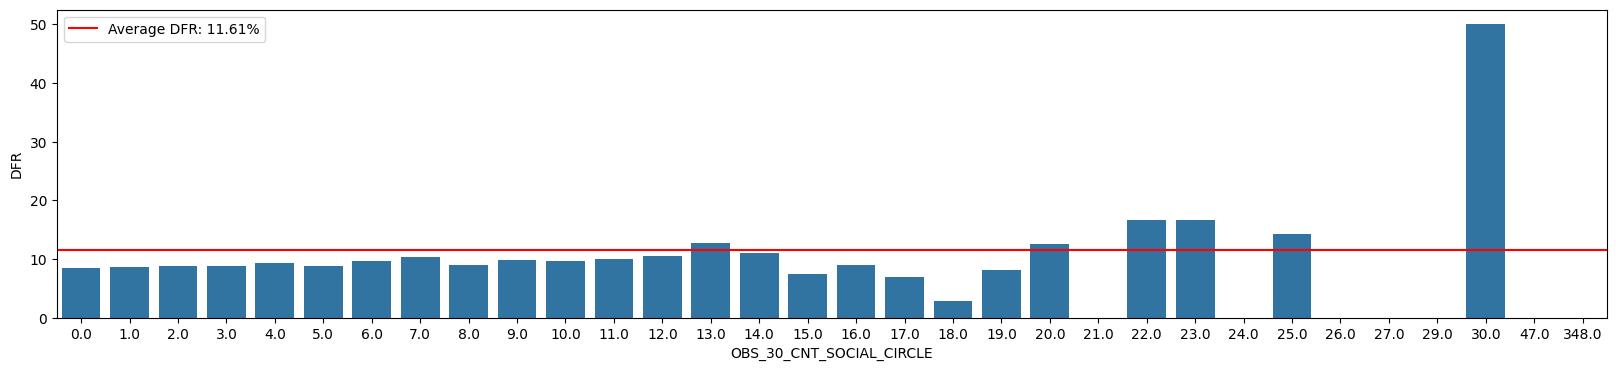

In [347]:
g.pctDfr(index='OBS_30_CNT_SOCIAL_CIRCLE', column=tg, value=pkey, groupby_flag=False)

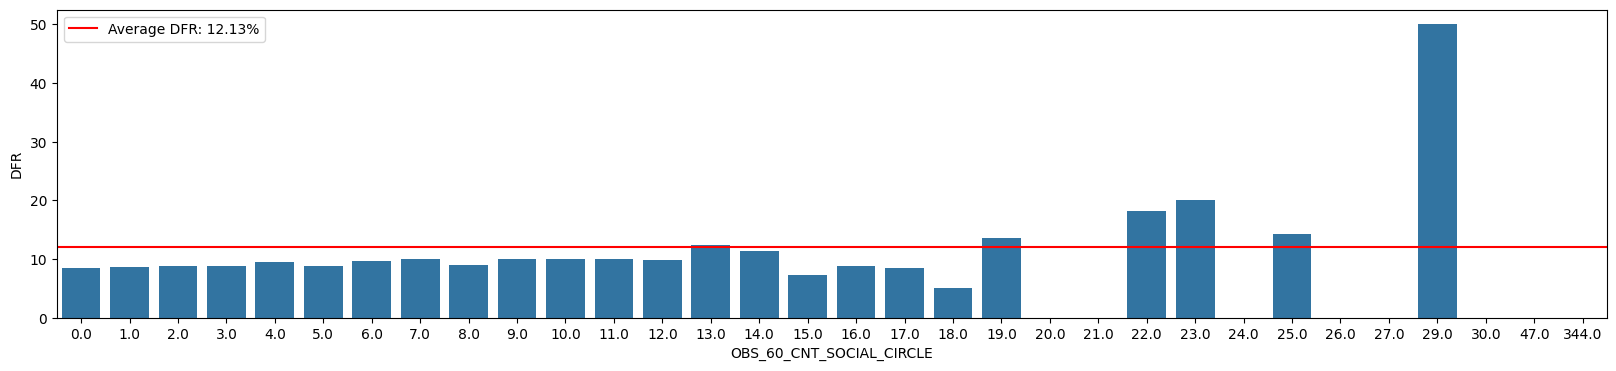

In [348]:
g.pctDfr(index='OBS_60_CNT_SOCIAL_CIRCLE', column=tg, value=pkey, groupby_flag=False)

In [364]:
df_application.groupby(['DEF_60_CNT_SOCIAL_CIRCLE'])[[pkey]].count()

,SK_ID_CURR
DEF_60_CNT_SOCIAL_CIRCLE,
0.0,230636
1.0,17521
2.0,2537
3.0,471
4.0,103
5.0,17
6.0,2
24.0,1


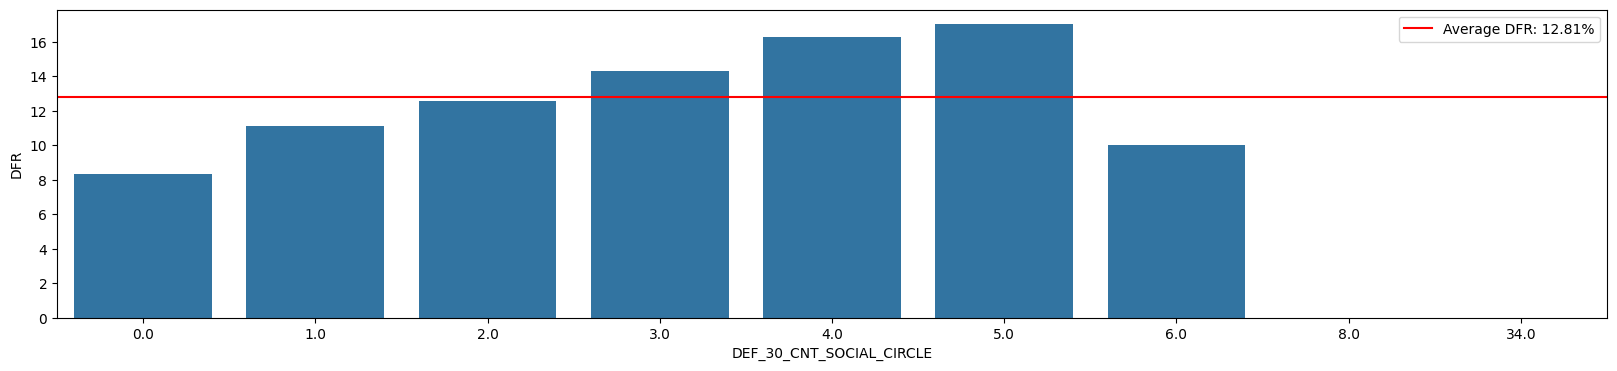

In [352]:
g.pctDfr(index='DEF_30_CNT_SOCIAL_CIRCLE', column=tg, value=pkey, groupby_flag=False)

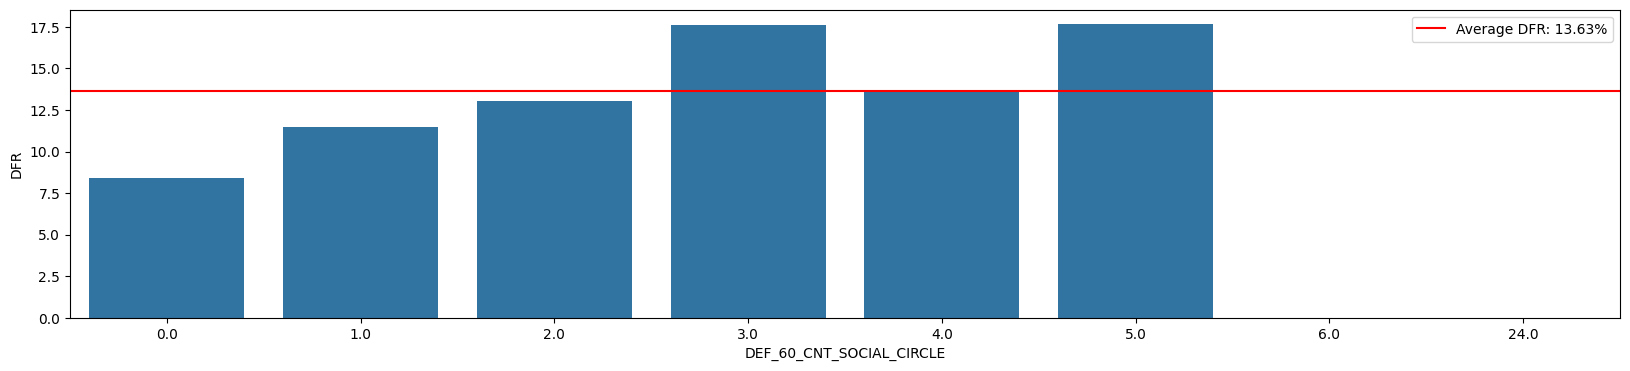

In [351]:
g.pctDfr(index='DEF_60_CNT_SOCIAL_CIRCLE', column=tg, value=pkey, groupby_flag=False)

Re-check missing data again

In [17]:
(round(df_application[df_application['OBS_60_CNT_SOCIAL_CIRCLE'] != 0].shape[0] * 100/ df_application.shape[0], 2))

46.45

In [18]:
round(df_application[df_application['OBS_30_CNT_SOCIAL_CIRCLE'] != 0].shape[0] * 100/ df_application.shape[0], 2)

46.7

In [19]:
df_application[(df_application['OBS_60_CNT_SOCIAL_CIRCLE'] != 0) & (df_application['OBS_30_CNT_SOCIAL_CIRCLE'] == 0)]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,P_INCOME_TOTAL,SPOUSE_CNT,OTH_FAMILY_MEMBER


In [ ]:
df_melted = df_application.melt(id_vars = [pkey, tg], value_vars = application_metadata['social_info'], var_name = 'SOCIAL_CIRCLE_DPD')

df_melted['DEFAULT_FLAG'] = df_melted.value.apply(lambda x: 1 if x > 0 else 0)
df_melted['SOCIAL_DAYS'] = df_melted.SOCIAL_CIRCLE_DPD.str.extract('(\d+)')

In [20]:
df_application['FRIEND_DEFAULT_FLAG'] = df_application['DEF_30_CNT_SOCIAL_CIRCLE'].apply(lambda x: 1 if x > 0 else 0)

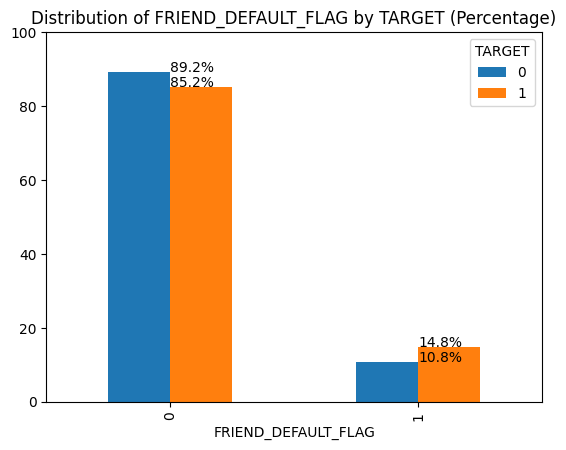

In [28]:
g.cat(index='FRIEND_DEFAULT_FLAG', columns='TARGET', values=pkey, aggfunc='count', p_flag=True)

## reachability

In [367]:
application_metadata['reachability']

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'NAME_TYPE_SUITE',
 'FLAG_CONT_MOBILE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

posx and posy should be finite values
posx and posy should be finite values


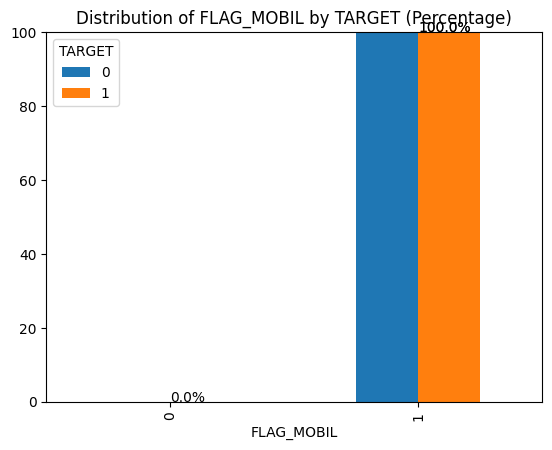

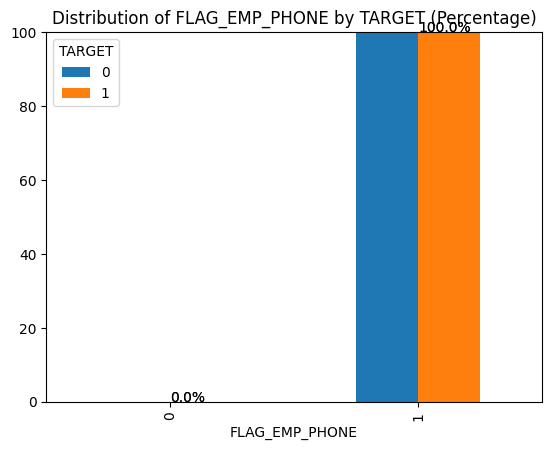

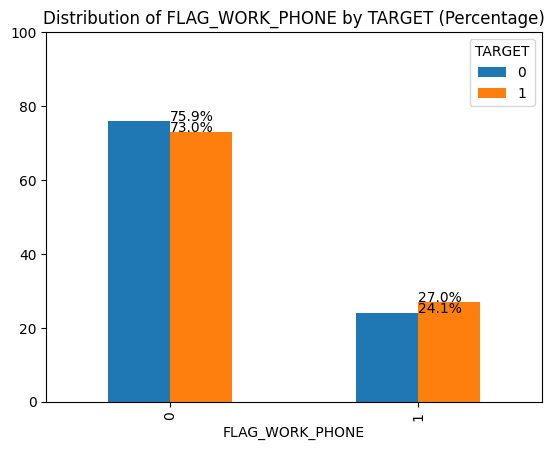

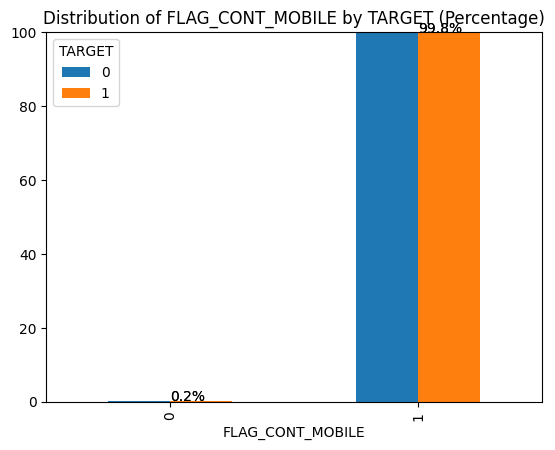

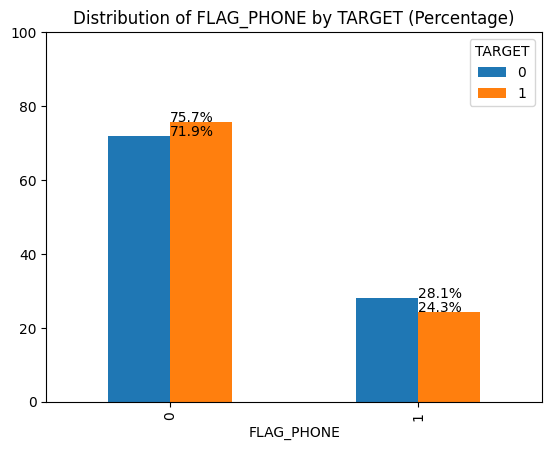

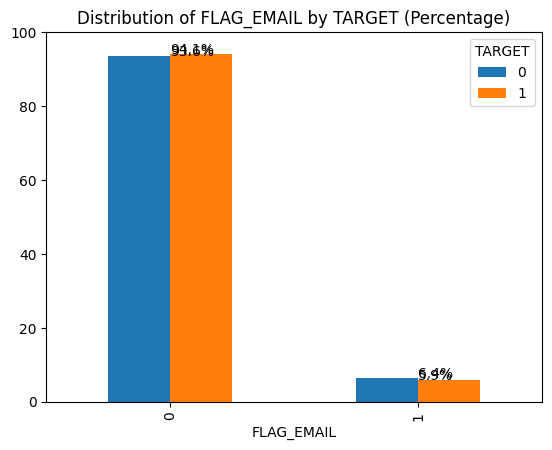

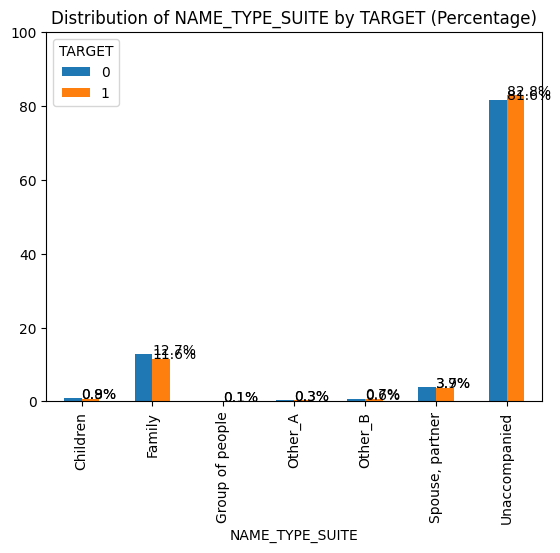

In [368]:
for col in application_metadata['reachability'][:7]:
    g.cat(col, tg, pkey, 'count', p_flag=True)

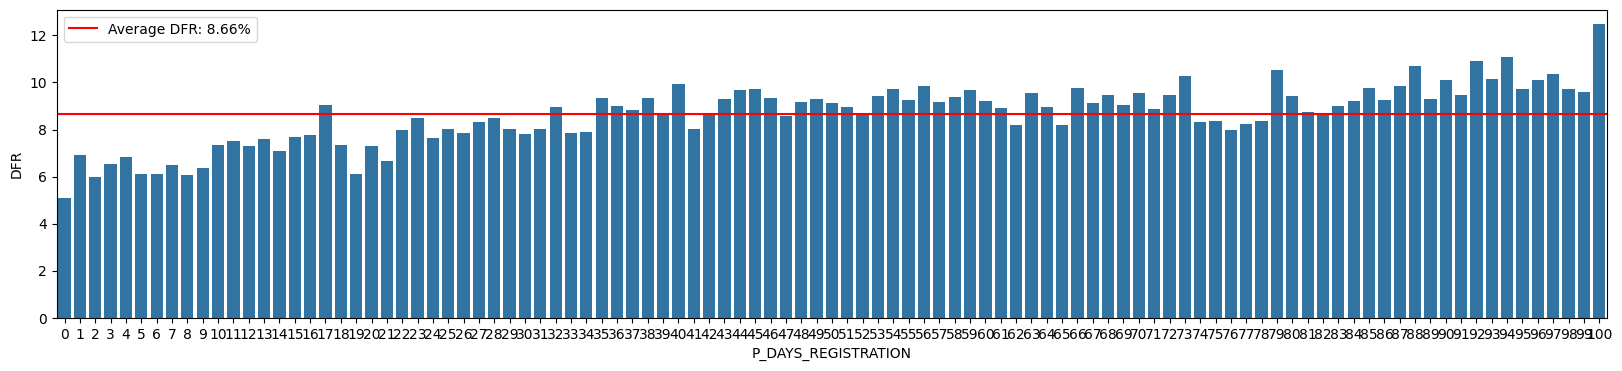

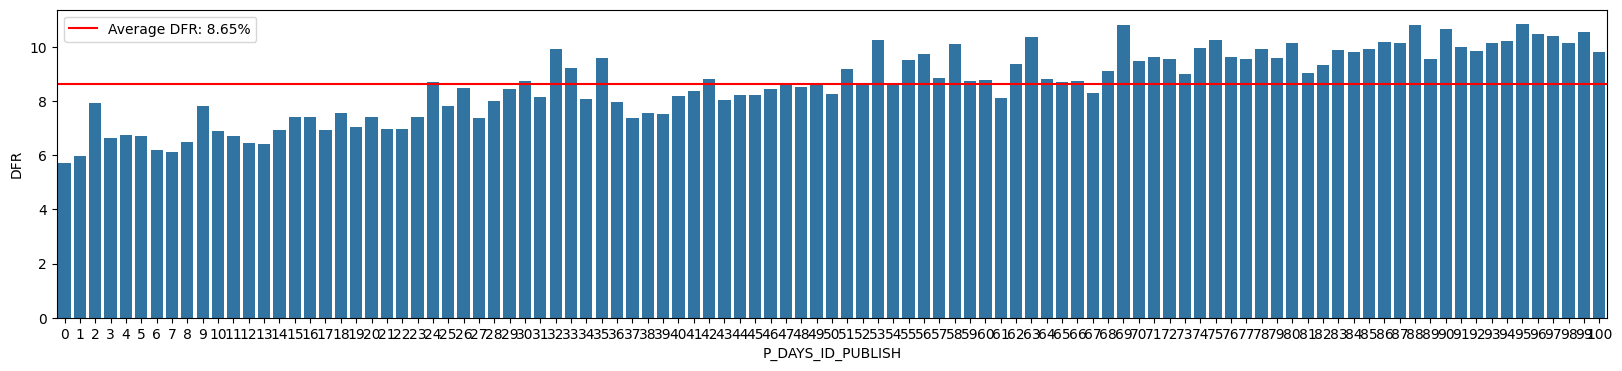

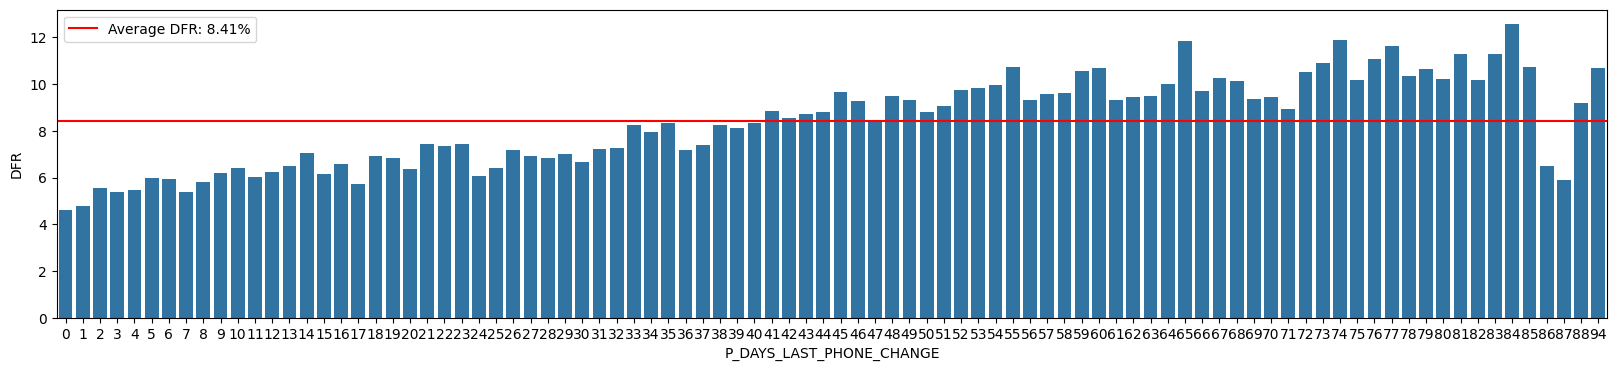

In [374]:
for col in ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']:
    g.pctDfr(col, tg, pkey, groupby_flag=True)

* ID expiration -> Continue?
* Last phone change -> Frequently following the trend?

## geo_info

Register | Live | Work

0 is same , 1 is diff

In [401]:
application_metadata['geo_info']

['REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

If the data is customer register the same region as live and work region, can work and live not in the same city?

In [419]:
application_metadata['geo_info']

['REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

* 0-0 = reg-home-work
* 1-0 = reg-home
* 0-1 = reg-work
* 0-0 = reg-outside

In [21]:
df_application['REGION_REG'] = df_application.apply(lambda row: "-".join([str(row[col]) for col in ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION']]), axis=1)
df_application['CITY_REG'] = df_application.apply(lambda row: "-".join([str(row[col]) for col in ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']]), axis=1)

In [22]:
df_application['REGION_REG'] = df_application['REGION_REG'].apply(lambda x: reg_area_config[x])
df_application['CITY_REG'] = df_application['CITY_REG'].apply(lambda x: reg_area_config[x])

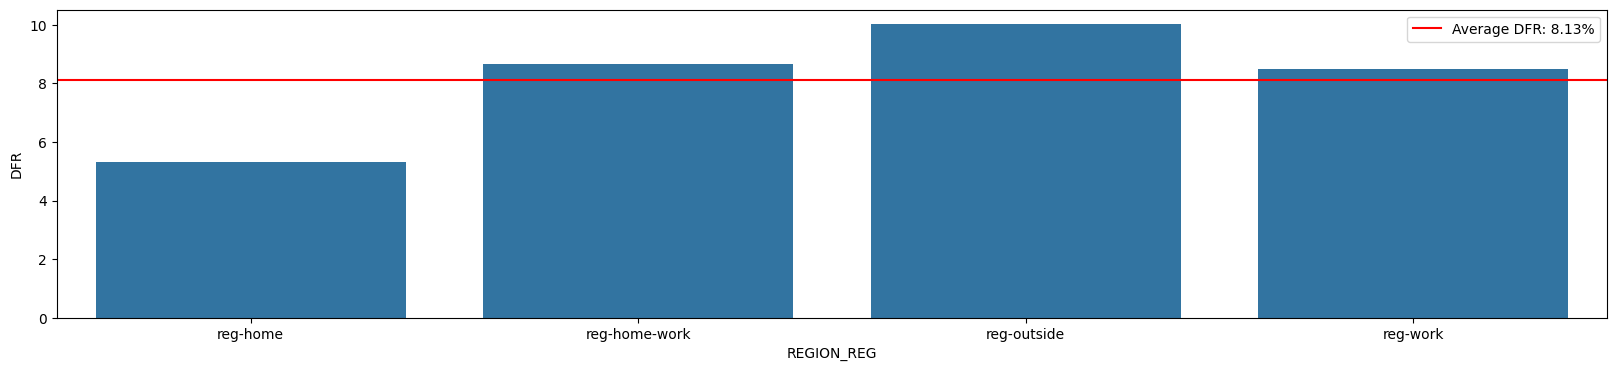

In [433]:
g.pctDfr('REGION_REG', groupby_flag=False)

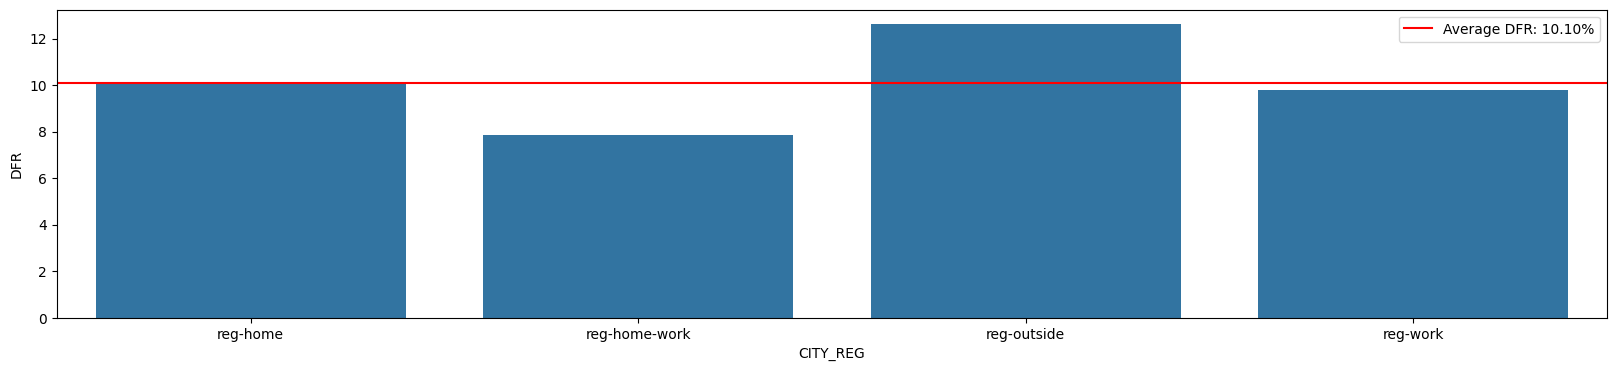

In [417]:
g.pctDfr('CITY_REG', tg, pkey, groupby_flag=False)

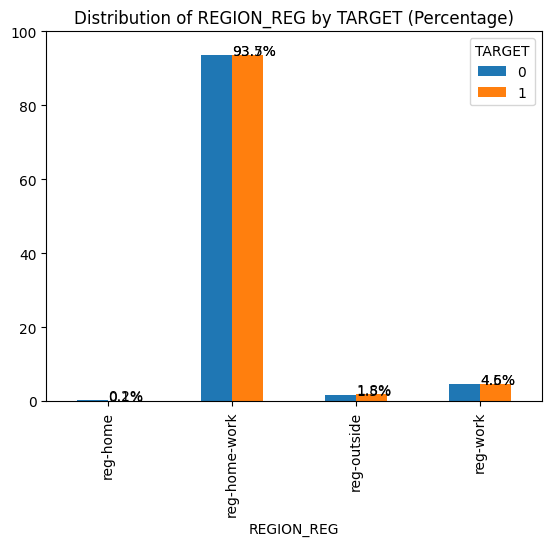

In [424]:
g.cat('REGION_REG', tg, pkey, aggfunc='count', p_flag=True)

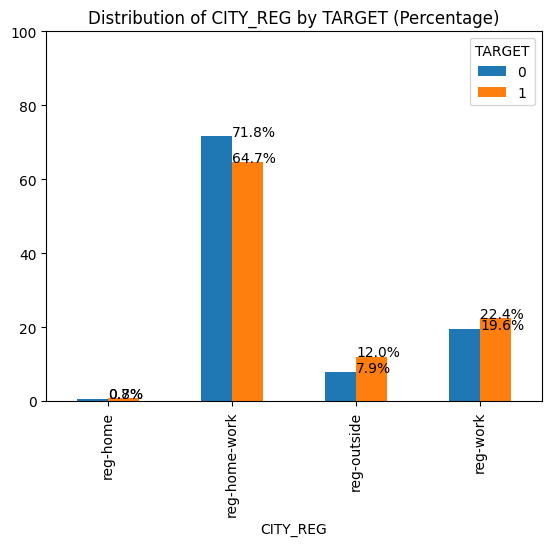

In [428]:
g.cat('CITY_REG')

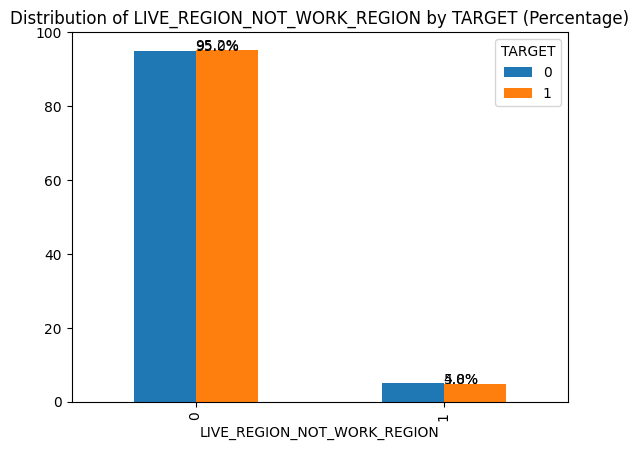

In [429]:
g.cat('LIVE_REGION_NOT_WORK_REGION')

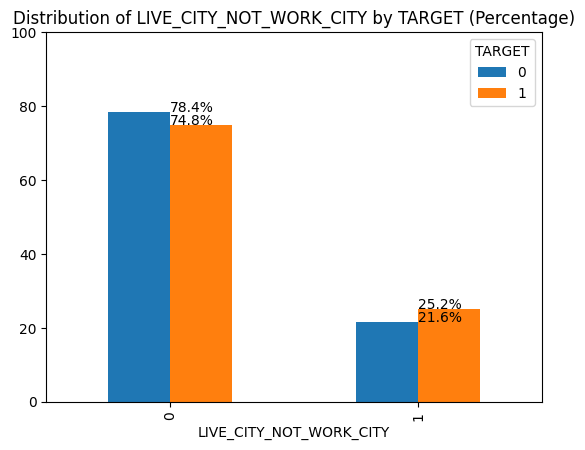

In [430]:
g.cat('LIVE_CITY_NOT_WORK_CITY')

## Document info

In [23]:
df_application[application_metadata['document_info'][:20]] = df_application[application_metadata['document_info'][:20]].astype(str)

In [24]:
df_application['DOCUMENTS'] = df_application[application_metadata['document_info'][:20]].agg('-'.join, axis=1)

In [25]:
df_pivot = df_application.pivot_table(index=['DOCUMENTS', ], columns='TARGET', values='SK_ID_CURR', aggfunc='count').reset_index().fillna(0)
df_pivot['DFR'] = round(df_pivot[1] * 100 / (df_pivot[1] +df_pivot[0]), 2)

In [26]:
df_pivot.sort_values(by='DFR', ascending=False)

TARGET,DOCUMENTS,0,1,DFR
55,0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-1,0.0,2.0,100.00
36,0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-1-1-0,0.0,1.0,100.00
24,0-0-0-0-0-0-1-0-0-0-0-0-0-0-1-0-0-0-1-1,0.0,1.0,100.00
22,0-0-0-0-0-0-1-0-0-0-0-0-0-0-1-0-0-0-0-1,0.0,1.0,100.00
18,0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-1-0-0-1,1.0,1.0,50.00
51,0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1,2.0,2.0,50.00
71,1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,9.0,4.0,30.77
56,0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-1-0,41.0,6.0,12.77
70,0-1-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0,37.0,5.0,11.90
65,0-1-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-1-0,8.0,1.0,11.11


In [448]:
df_application[application_metadata['document_info'][:20]] = df_application[application_metadata['document_info'][:20]].astype(int)

In [27]:
df_application['MISSING_DOC'] = df_application[application_metadata['document_info'][:20]].sum(axis=1)

In [465]:
df_pivot = df_application.pivot_table(index=['MISSING_DOC', ], columns='TARGET', values='SK_ID_CURR', aggfunc='count').reset_index().fillna(0)
df_pivot['DFR'] = round(df_pivot[1] * 100 / (df_pivot[1] +df_pivot[0]), 2)
df_pivot

TARGET,MISSING_DOC,0,1,DFR
0,0,24762.0,1466.0,5.59
1,1,198113.0,19993.0,9.17
2,2,7281.0,359.0,4.70
3,3,146.0,16.0,9.88
4,4,0.0,1.0,100.00


Location seem to matter than how much it missing

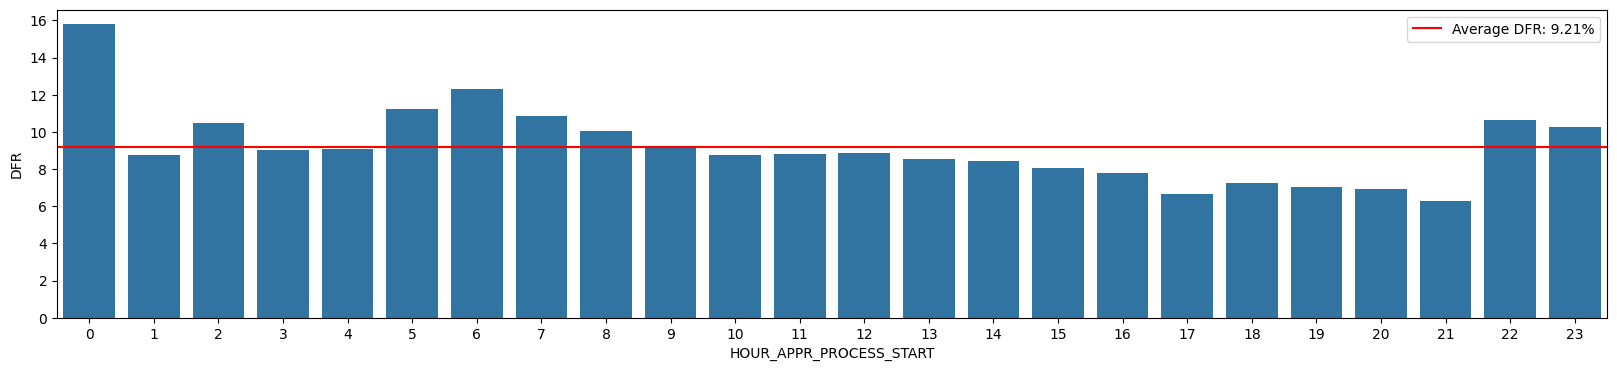

In [470]:
g.pctDfr('HOUR_APPR_PROCESS_START', groupby_flag=False)

In [471]:
df_application.groupby('HOUR_APPR_PROCESS_START')[[pkey]].count()

,SK_ID_CURR
HOUR_APPR_PROCESS_START,
0,38
1,80
2,267
3,1033
4,1706
5,2920
6,4569
7,7127
8,11581


In [28]:
df_application['APPL_WKND_FLAG'] = df_application.WEEKDAY_APPR_PROCESS_START.apply(lambda x: 1 if x in ['SATURDAY', 'SUNDAY'] else 0)

In [663]:
to_pivot = df_application.pivot_table(index = ['APPL_WKND_FLAG', 'OCCUPATION_TYPE', ], columns='TARGET', values=pkey, aggfunc='count').reset_index()

In [666]:
to_pivot['DFR'] = to_pivot[1] / (to_pivot[0]+to_pivot[1])

<Axes: xlabel='OCCUPATION_TYPE', ylabel='DFR'>

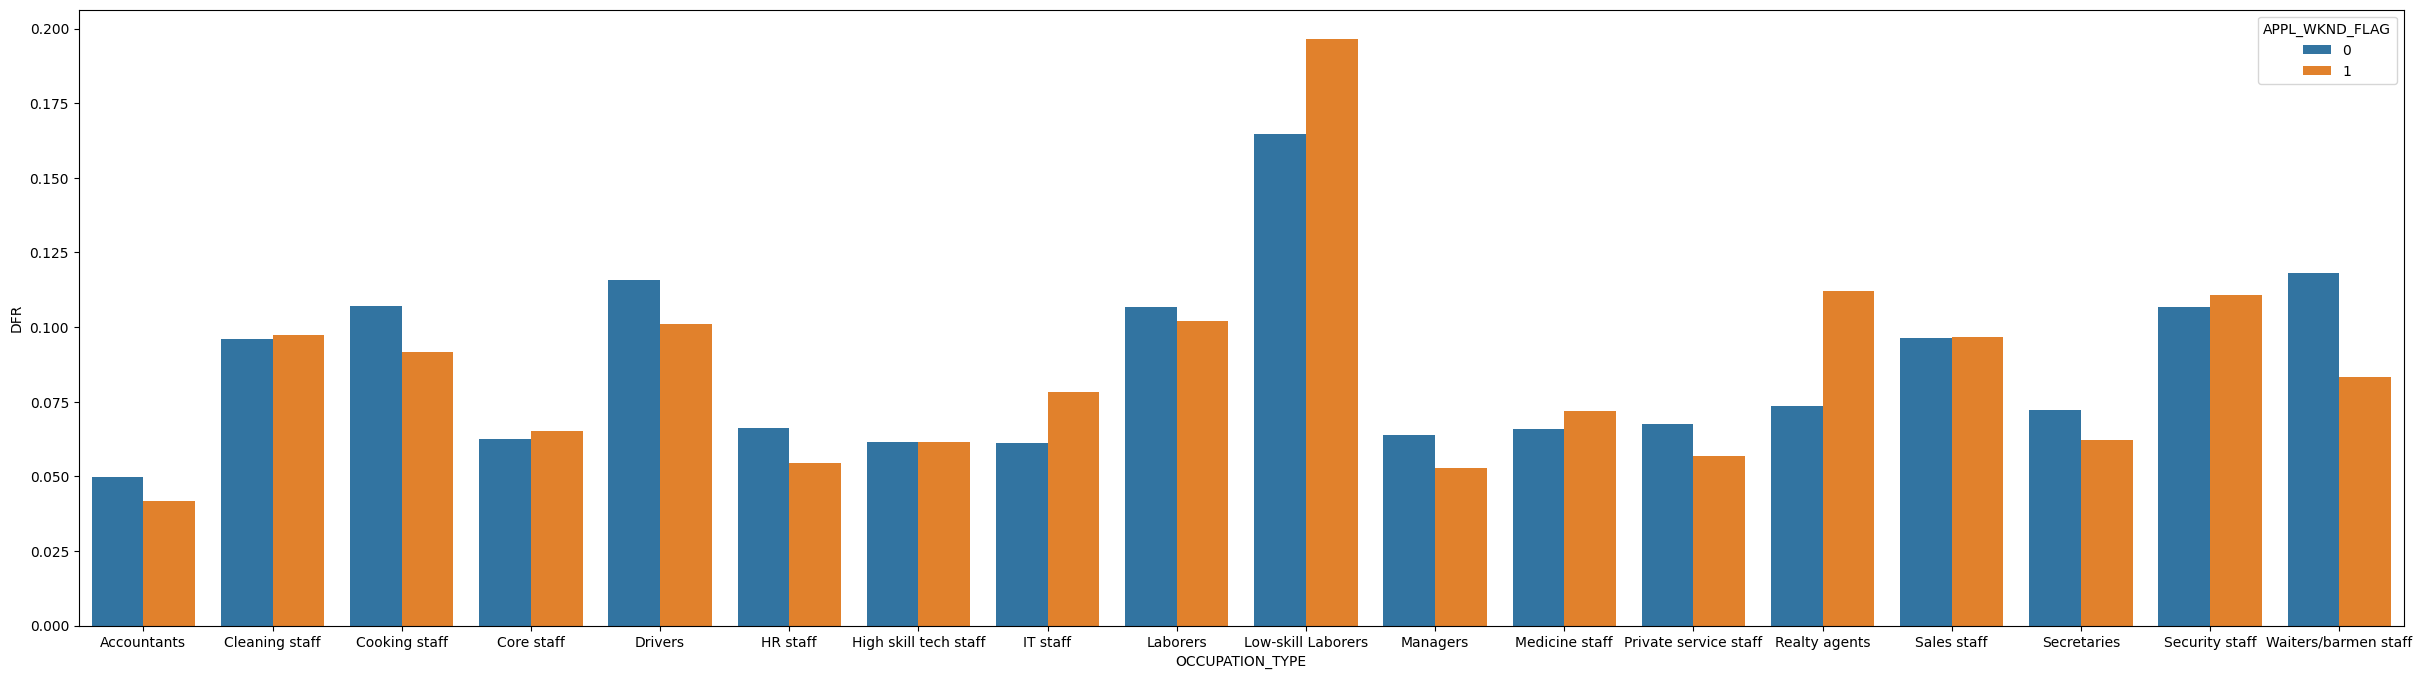

In [677]:
plt.figure(figsize=(30,8))
sns.barplot(to_pivot, x='OCCUPATION_TYPE', y='DFR', hue='APPL_WKND_FLAG')

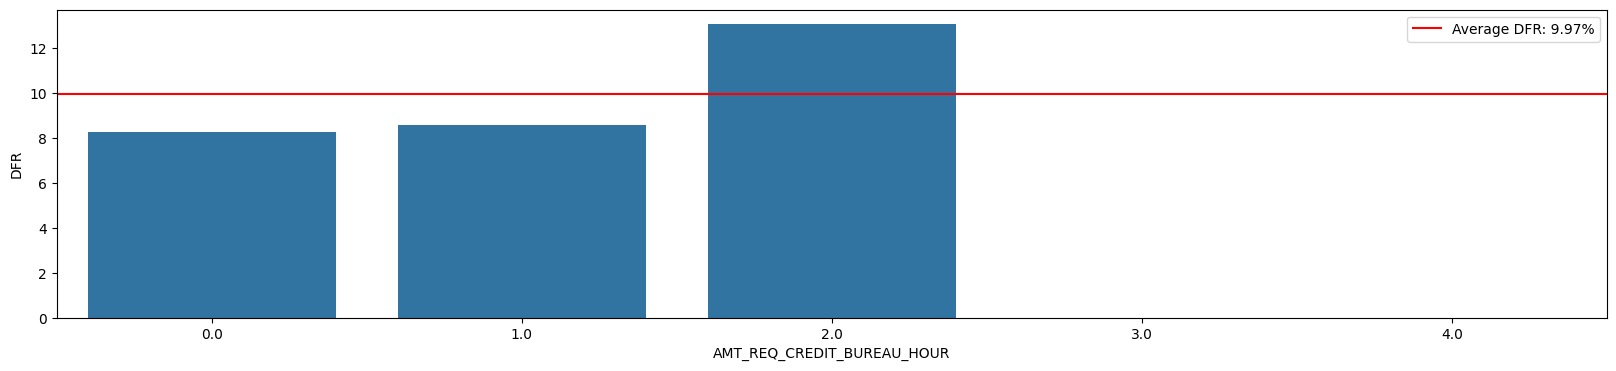

In [473]:
g.pctDfr('AMT_REQ_CREDIT_BUREAU_HOUR', groupby_flag=False)

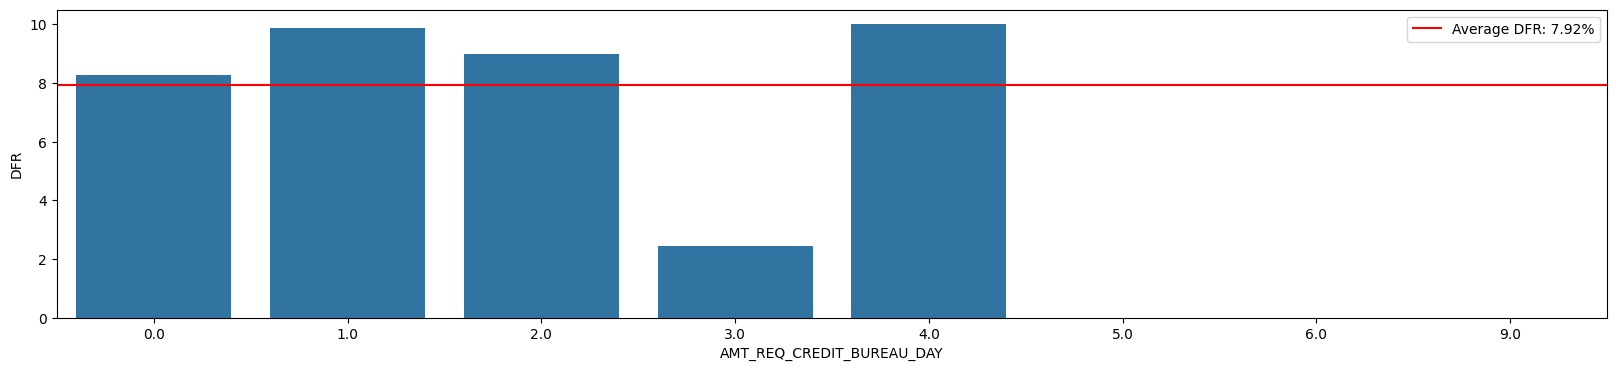

In [474]:
g.pctDfr('AMT_REQ_CREDIT_BUREAU_DAY', groupby_flag=False)

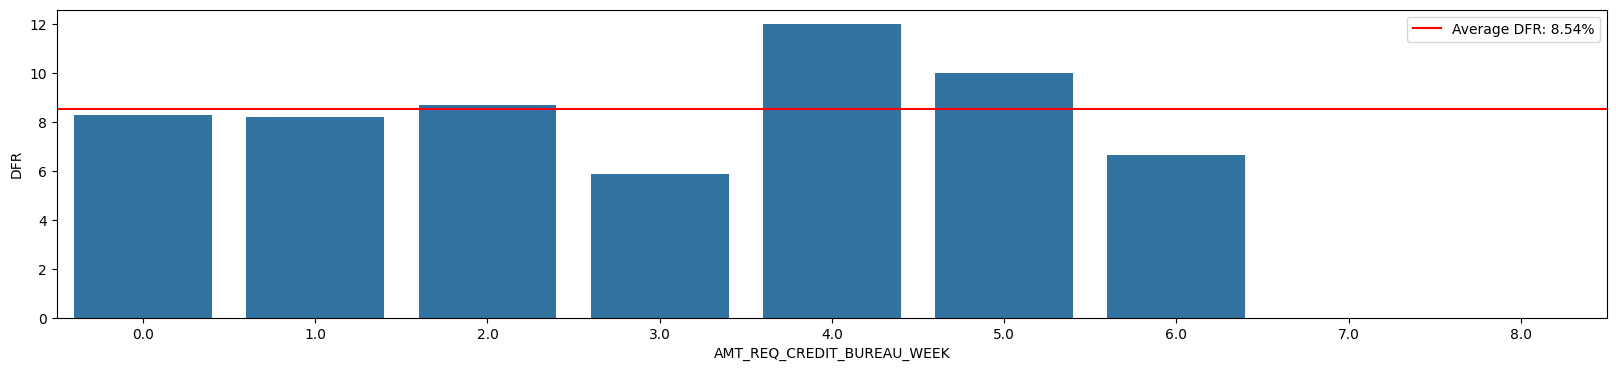

In [475]:
g.pctDfr('AMT_REQ_CREDIT_BUREAU_WEEK', groupby_flag=False)

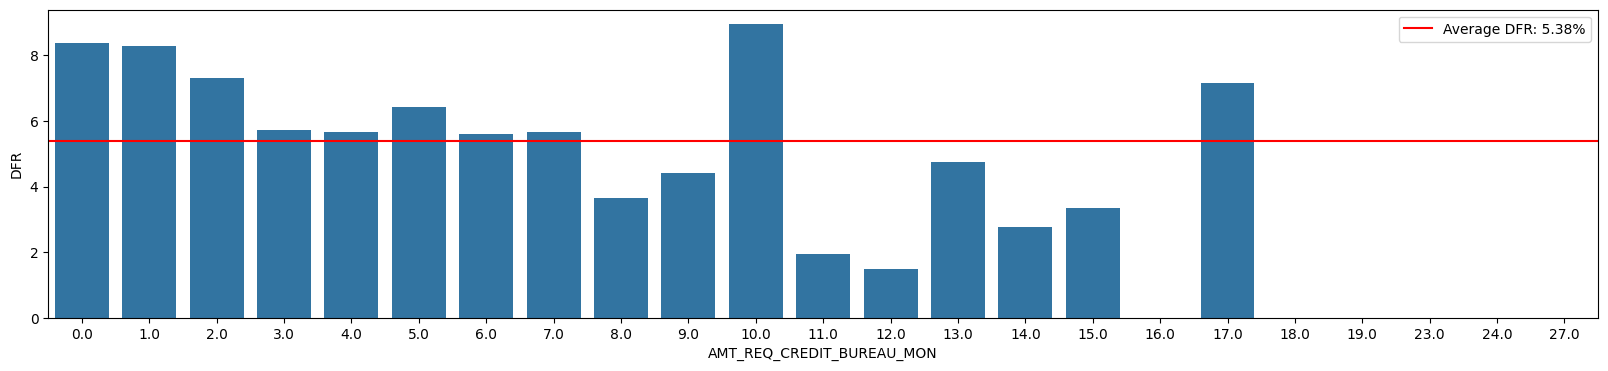

In [476]:
g.pctDfr('AMT_REQ_CREDIT_BUREAU_MON', groupby_flag=False)

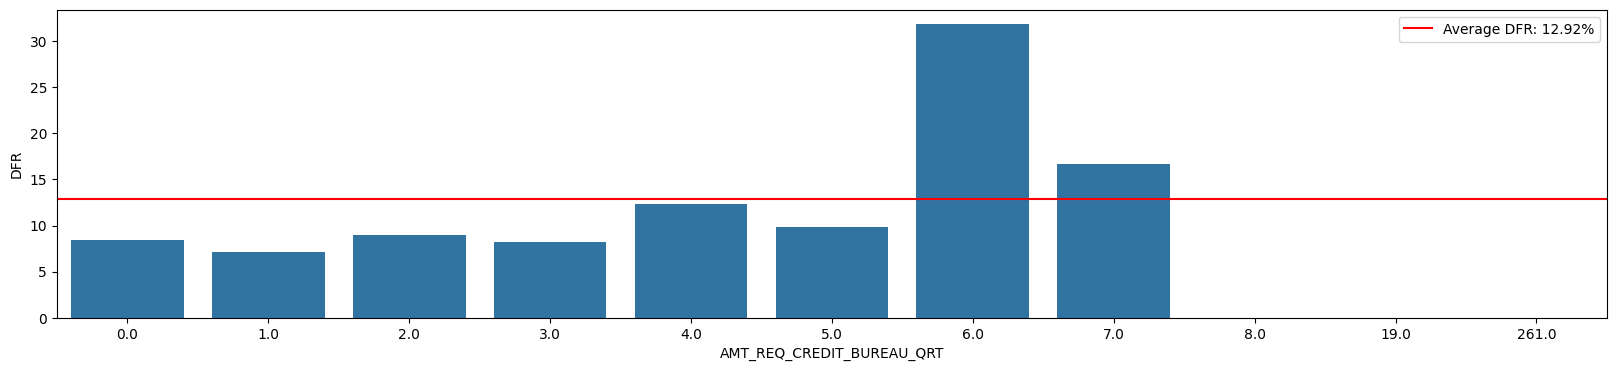

In [477]:
g.pctDfr('AMT_REQ_CREDIT_BUREAU_QRT', groupby_flag=False)

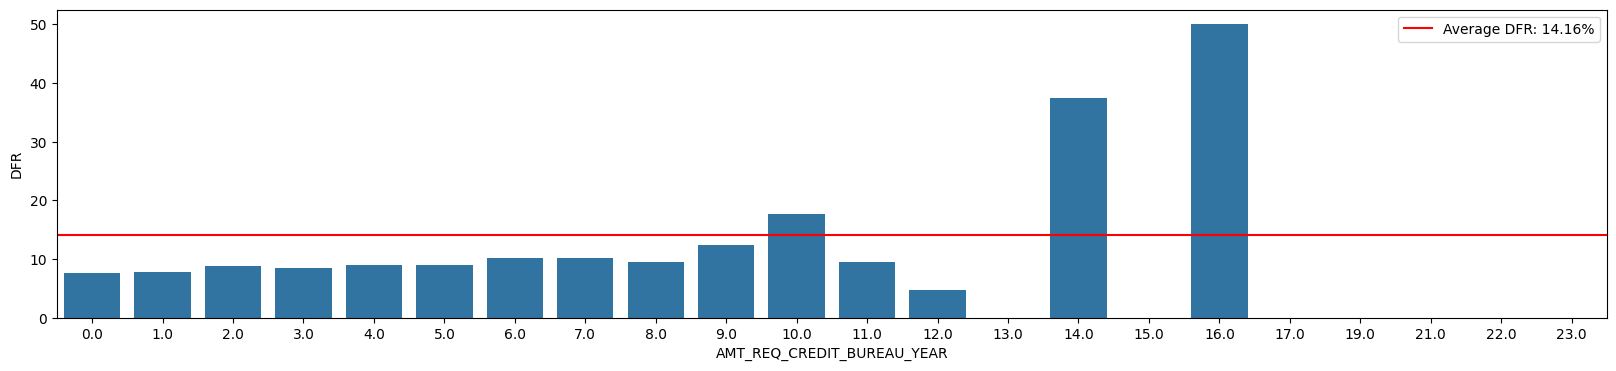

In [478]:
g.pctDfr('AMT_REQ_CREDIT_BUREAU_YEAR', groupby_flag=False)

In [479]:
df_application.groupby('AMT_REQ_CREDIT_BUREAU_YEAR')[[pkey]].count()

,SK_ID_CURR
AMT_REQ_CREDIT_BUREAU_YEAR,
0.0,59332
1.0,53259
2.0,41607
3.0,27331
4.0,16683
5.0,9417
6.0,5307
7.0,2892
8.0,1571


## external_info

In [483]:
df_application[application_metadata['external_info']+[pkey]]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_CURR
0,0.083037,0.262949,0.139376,100002
1,0.311267,0.622246,NaN,100003
2,NaN,0.555912,0.729567,100004
3,NaN,0.650442,NaN,100006
4,NaN,0.322738,NaN,100007
...,...,...,...,...
252132,NaN,0.530725,NaN,456248
252133,0.145570,0.681632,NaN,456251
252134,0.744026,0.535722,0.218859,456253
252135,NaN,0.514163,0.661024,456254


check with correlation

## loan_info

In [484]:
application_metadata['loan_info']

['AMT_CREDIT', 'AMT_ANNUITY', 'NAME_CONTRACT_TYPE', 'AMT_GOODS_PRICE']

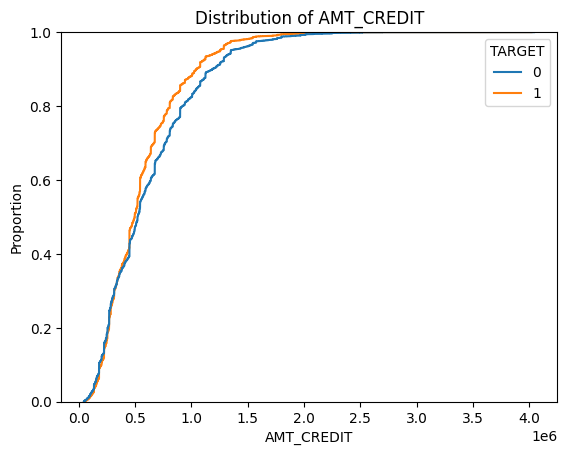

In [491]:
g.cdf(index='AMT_CREDIT', values='TARGET')

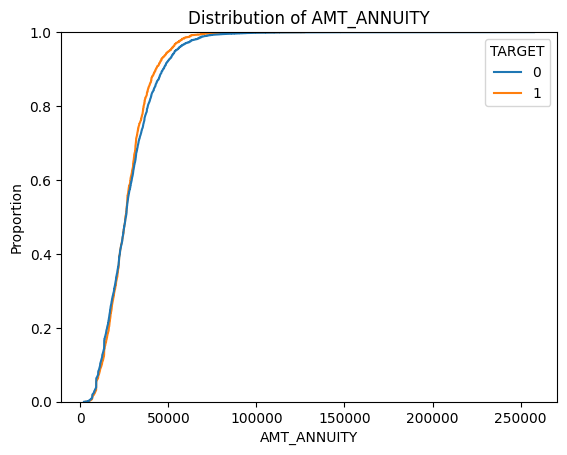

In [487]:
g.cdf(index='AMT_ANNUITY', values='TARGET')

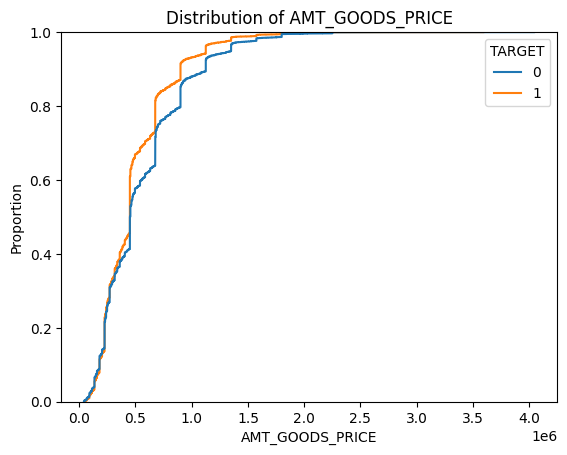

In [488]:
g.cdf(index='AMT_GOODS_PRICE', values='TARGET')

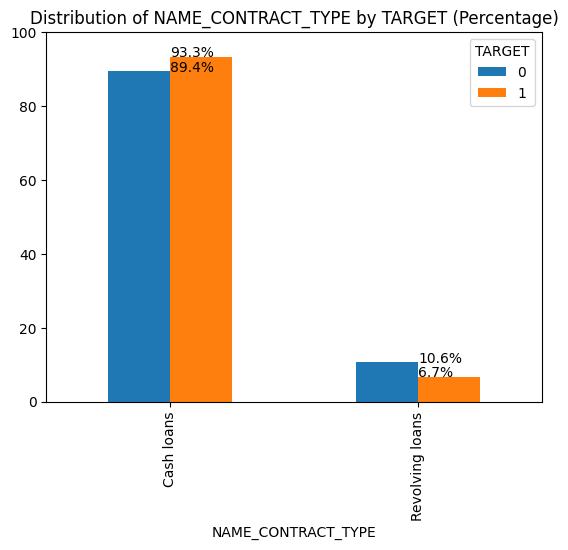

In [492]:
g.cat('NAME_CONTRACT_TYPE')

In [515]:
df_application['N_REPAYMENT'] = np.ceil(df_application['AMT_CREDIT'] / df_application['AMT_ANNUITY'])

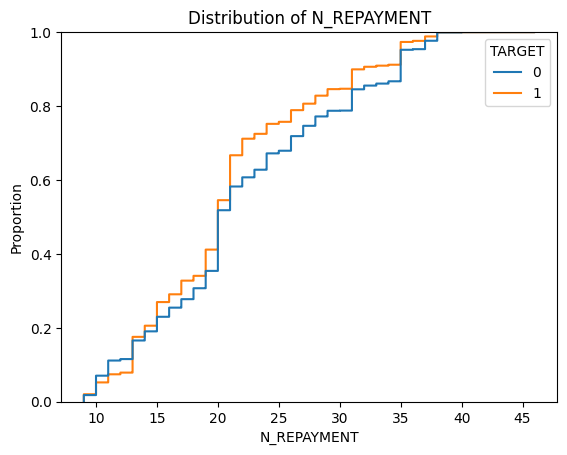

In [530]:
g.cdf('N_REPAYMENT')

Derive loan planning feature, the decision making that borrow higher/ lower/ exact for the exact propose might indicate something

In [29]:
def _derive_loan_planning(row):
    AMT_GOODS_PRICE = row['AMT_GOODS_PRICE']
    AMT_CREDIT = row['AMT_CREDIT']
    if AMT_GOODS_PRICE == AMT_CREDIT:
        return 'exact'
    elif AMT_GOODS_PRICE > AMT_CREDIT:
        return 'lower'
    elif AMT_GOODS_PRICE < AMT_CREDIT:
        return 'higher'

In [31]:
df_application['LOAN_PLANNING'] = df_application.apply(lambda row: _derive_loan_planning(row), axis=1)
# g.cat('LOAN_PLANNING')

In [32]:
df_application['BURDEN_PERCENTAGE'] = df_application['AMT_ANNUITY'] / df_application['AMT_INCOME_TOTAL']
df_application['RISK_REWARD_RATIO'] = df_application['AMT_CREDIT'] / df_application['AMT_INCOME_TOTAL']

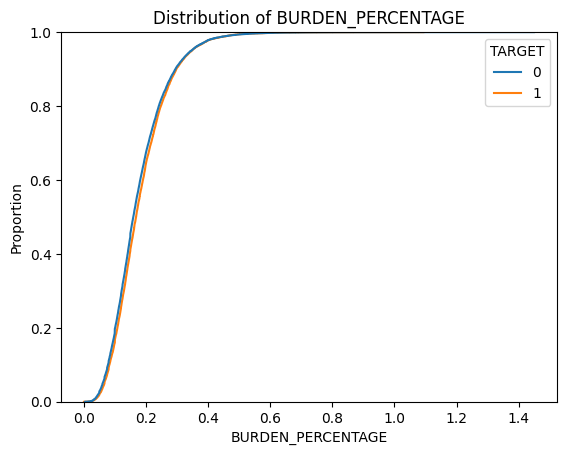

In [529]:
g.cdf('BURDEN_PERCENTAGE')

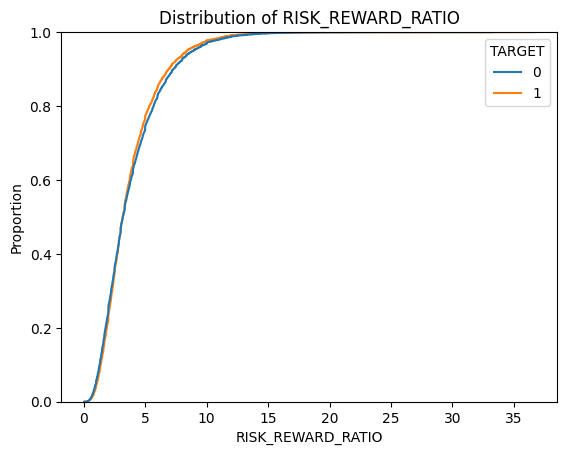

In [528]:
g.cdf('RISK_REWARD_RATIO')

Find saving and consumption?

In [538]:
df_application[df_application.SK_ID_CURR.isin(df_prev_app.SK_ID_CURR)].shape[0] * 100 / df_application.shape[0]

94.57874092259367

In [36]:
df_bureau = pipeline.importData('bureau')

# Experience with loan

Aim to derive the how much loan they successfully borrow and closed

In [40]:
n_prev_app = df_prev_app[df_prev_app[pkey].isin(df_application[pkey].unique())][pkey].nunique()
n_all = df_application.shape[0]

print('Have previous application data:', f'{round(n_prev_app * 100 / n_all, 2)}%')

Have previous application data: 94.58%


In [33]:
df_pivot_prev_app = df_prev_app[df_prev_app['NAME_CONTRACT_TYPE'] != 'XNA'].pivot_table(index=pkey, columns=['NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS'], values='SK_ID_PREV', aggfunc='count').fillna(0).reset_index()

In [37]:
df_all_loan = df_bureau.groupby(pkey)[['SK_ID_BUREAU']].count().reset_index()
df_all_loan.columns = [pkey, 'CNT_BR_PREV_LOAN']

In [38]:
df_pivot_prev_app.columns = ['SK_ID_CURR', 'CL_AP', 'CL_CN', 'CL_RF', 'CL_OU', 
                             'CSML_AP', 'CSML_CN', 'CSML_RF', 'CSML_OU',
                             'RL_AP', 'RL_CN', 'RL_RF', 'RL_OU',
                             ]

In [39]:
df_pivot_prev_app['CNT_PREV_APPR'] = df_pivot_prev_app['CL_AP']+df_pivot_prev_app['CSML_AP']+df_pivot_prev_app['RL_AP']
df_pivot_prev_app['CNT_PREV_CANC'] = df_pivot_prev_app['CL_CN']+df_pivot_prev_app['CSML_CN']+df_pivot_prev_app['RL_CN']
df_pivot_prev_app['CNT_PREV_RFUS'] = df_pivot_prev_app['CL_RF']+df_pivot_prev_app['CSML_RF']+df_pivot_prev_app['RL_RF']
df_pivot_prev_app['CNT_PREV_NUSE'] = df_pivot_prev_app['CL_OU']+df_pivot_prev_app['CSML_OU']+df_pivot_prev_app['RL_OU']

In [40]:
df_pivot_prev_app['CNT_PREV_TOTL'] = df_pivot_prev_app['CNT_PREV_APPR']+df_pivot_prev_app['CNT_PREV_CANC']+df_pivot_prev_app['CNT_PREV_RFUS']+df_pivot_prev_app['CNT_PREV_NUSE']

df_pivot_prev_app['PCT_PREV_APPR'] = df_pivot_prev_app['CNT_PREV_APPR'] *100/ df_pivot_prev_app['CNT_PREV_TOTL']
df_pivot_prev_app['PCT_PREV_CANC'] = df_pivot_prev_app['CNT_PREV_CANC'] *100 / df_pivot_prev_app['CNT_PREV_TOTL']
df_pivot_prev_app['PCT_PREV_RFUS'] = df_pivot_prev_app['CNT_PREV_RFUS'] *100 / df_pivot_prev_app['CNT_PREV_TOTL']
df_pivot_prev_app['PCT_PREV_NUSE'] = df_pivot_prev_app['CNT_PREV_NUSE'] *100 / df_pivot_prev_app['CNT_PREV_TOTL']

In [41]:
df_pivot_prev_app = df_pivot_prev_app.merge(df_application[[pkey, 'TARGET']], on=pkey, how='inner')

In [42]:
df_pivot_prev_app = df_pivot_prev_app.merge(df_all_loan, on=pkey, how='inner')

In [43]:
df_pivot_prev_app['PCT_HMLOAN'] = df_pivot_prev_app['CNT_PREV_TOTL'] *100 / (df_pivot_prev_app['CNT_PREV_LOAN'] + 1)

In [63]:
df_pivot_prev_app

,SK_ID_CURR,CL_AP,CL_CN,CL_RF,CL_OU,CSML_AP,CSML_CN,CSML_RF,CSML_OU,RL_AP,RL_CN,RL_RF,RL_OU,CNT_PREV_APPR,CNT_PREV_CANC,CNT_PREV_RFUS,CNT_PREV_NUSE,CNT_PREV_TOTL,PCT_PREV_APPR,PCT_PREV_CANC,PCT_PREV_RFUS,PCT_PREV_NUSE,TARGET,CNT_PREV_LOAN,PCT_HMLOAN
0,100002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,1,8,11.111111
1,100003,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,0,4,60.000000
2,100004,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,0,2,33.333333
3,100007,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,100.0,0.0,0.0,0.0,0,1,300.000000
4,100008,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,5.0,80.0,20.0,0.0,0.0,0,3,125.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249502,456247,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,5.0,80.0,0.0,20.0,0.0,0,11,41.666667
249503,456249,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,50.0,0.0,50.0,0.0,0,13,14.285714
249504,456253,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,0,4,40.000000
249505,456254,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,1,1,100.000000


In [44]:
df_pivot_prev_app[df_pivot_prev_app['PCT_HMLOAN'] > 100]

,SK_ID_CURR,CL_AP,CL_CN,CL_RF,CL_OU,CSML_AP,CSML_CN,CSML_RF,CSML_OU,RL_AP,RL_CN,RL_RF,RL_OU,CNT_PREV_APPR,CNT_PREV_CANC,CNT_PREV_RFUS,CNT_PREV_NUSE,CNT_PREV_TOTL,PCT_PREV_APPR,PCT_PREV_CANC,PCT_PREV_RFUS,PCT_PREV_NUSE,TARGET,CNT_PREV_LOAN,PCT_HMLOAN
3,100007,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,100.000000,0.000000,0.000000,0.0,0,1,300.000000
4,100008,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,5.0,80.000000,20.000000,0.000000,0.0,0,3,125.000000
16,100025,4.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,8.0,87.500000,12.500000,0.000000,0.0,0,1,400.000000
20,100030,0.0,0.0,0.0,0.0,2.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,0.0,12.0,16.666667,0.000000,83.333333,0.0,0,6,171.428571
23,100035,5.0,6.0,8.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,8.0,0.0,22.0,36.363636,27.272727,36.363636,0.0,0,9,220.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249491,456235,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,5.0,80.000000,20.000000,0.000000,0.0,0,3,125.000000
249493,456237,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,2.0,1.0,0.0,9.0,66.666667,22.222222,11.111111,0.0,0,1,450.000000
249496,456240,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,5.0,80.000000,20.000000,0.000000,0.0,0,2,166.666667
249497,456241,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,9.0,66.666667,33.333333,0.000000,0.0,0,5,150.000000


In [700]:
df_bureau.CREDIT_TYPE.unique()

array(['Consumer credit', 'Credit card', 'Mortgage', 'Car loan',
       'Microloan', 'Loan for working capital replenishment',
       'Loan for business development', 'Real estate loan',
       'Unknown type of loan', 'Another type of loan',
       'Cash loan (non-earmarked)', 'Loan for the purchase of equipment',
       'Mobile operator loan', 'Interbank credit',
       'Loan for purchase of shares (margin lending)'], dtype=object)

In [699]:
df_bureau[df_bureau[pkey] == 100007]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1503966,100007,5987200,Closed,currency 1,-1149,0,-783.0,-783.0,0.0,0,146250.0,0.0,0.0,0.0,Consumer credit,-783,NaN


In [698]:
df_prev_app[df_prev_app[pkey] == 100007]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INCOME_TOTAL,TARGET,PREV_BURDEN_PERCENTAGE,PREV_RISK_REWARD_RATIO
9177,2001242,100007,Cash loans,16509.600,180000.0,180000.0,NaN,180000.0,SUNDAY,14,Y,1,NaN,NaN,NaN,XNA,Approved,-865,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,walk-in,Regional / Local,1200,Consumer electronics,18.0,high,Cash Street: high,365243.0,-834.0,-324.0,-354.0,-347.0,0.0,121500.0,0,0.135881,1.481481
59949,2730157,100007,Cash loans,13010.985,225000.0,284400.0,NaN,225000.0,FRIDAY,13,Y,1,NaN,NaN,NaN,XNA,Approved,-867,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),4,XNA,48.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN,121500.0,0,0.107086,2.340741
473334,1692033,100007,Cash loans,16037.640,247500.0,274288.5,NaN,247500.0,MONDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-374,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-344.0,346.0,365243.0,365243.0,1.0,121500.0,0,0.131997,2.257519
724128,2119973,100007,Consumer loans,1834.290,17176.5,14616.0,3676.5,17176.5,SATURDAY,13,Y,1,0.218890,NaN,NaN,XAP,Approved,-2357,Cash through the bank,XAP,Family,New,Audio/Video,POS,XNA,Country-wide,1200,Consumer electronics,10.0,high,POS household with interest,365243.0,-2326.0,-2056.0,-2056.0,-2041.0,1.0,121500.0,0,0.015097,0.120296
860124,2462742,100007,Consumer loans,3601.530,31005.0,30663.0,3105.0,31005.0,SUNDAY,15,Y,1,0.100143,NaN,NaN,XAP,Approved,-1768,Cash through the bank,XAP,Unaccompanied,Repeater,Audio/Video,POS,XNA,Country-wide,53,Connectivity,12.0,high,POS mobile with interest,365243.0,-1736.0,-1406.0,-1406.0,-1397.0,0.0,121500.0,0,0.029642,0.252370
1012606,1940724,100007,Cash loans,22678.785,202500.0,215865.0,NaN,202500.0,THURSDAY,8,Y,1,NaN,NaN,NaN,XNA,Approved,-1106,XNA,XAP,NaN,Repeater,XNA,Cash,x-sell,Country-wide,-1,Consumer electronics,12.0,middle,Cash X-Sell: middle,365243.0,-1076.0,-746.0,-746.0,-739.0,1.0,121500.0,0,0.186657,1.776667


In [705]:
x = df_prev_app[(df_prev_app['NAME_PRODUCT_TYPE'] == 'walk-in') & (df_prev_app['NAME_CONTRACT_STATUS'] == 'Approved')].groupby(pkey)[['SK_ID_PREV']].count().reset_index()

In [706]:
x = x.merge(df_all_loan, on=pkey, how='inner')

In [711]:
x[x['SK_ID_PREV'] > (x['CNT_PREV_LOAN']+1)].shape[0]

130

In [712]:
del df_pivot_prev_app['PCT_HMLOAN'] 

In [715]:
df_pivot_prev_app['HMLOAN_LOYALTY'] = df_pivot_prev_app.apply(lambda r: 1 if r['CNT_PREV_TOTL'] >= r['CNT_PREV_LOAN'] else 0, axis=1)

In [716]:
gpv = graphVisualizer(df_pivot_prev_app)

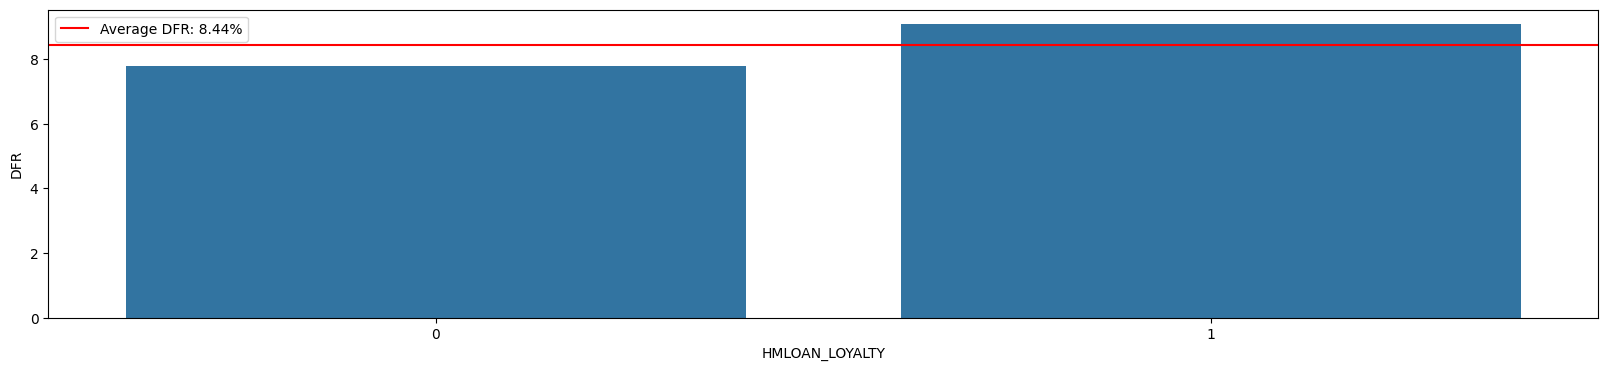

In [719]:
gpv.pctDfr('HMLOAN_LOYALTY', groupby_flag=False)

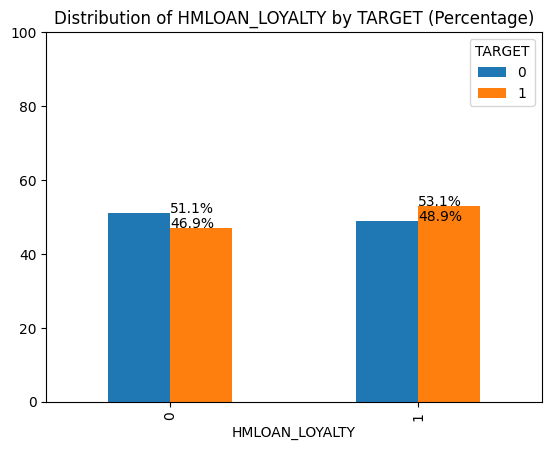

In [717]:
gpv.cat('HMLOAN_LOYALTY')

In [624]:
df_pivot_prev_app.groupby('CNT_PREV_APPR')[['SK_ID_CURR']].count()

,SK_ID_CURR
CNT_PREV_APPR,
0.0,803
1.0,63073
2.0,56284
3.0,43249
4.0,29128
5.0,18671
6.0,11440
7.0,6738
8.0,3849


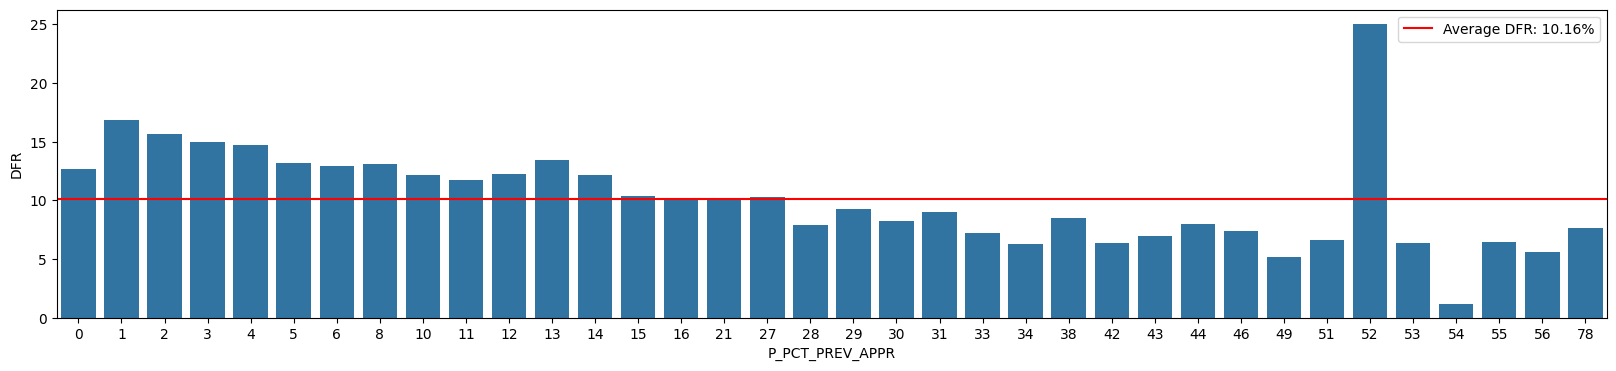

In [630]:
gpv.pctDfr('PCT_PREV_APPR', groupby_flag=True)

In [625]:
df_pivot_prev_app.groupby('CNT_PREV_CANC')[['SK_ID_CURR']].count()

,SK_ID_CURR
CNT_PREV_CANC,
0.0,150583
1.0,40613
2.0,20802
3.0,11169
4.0,6259
5.0,3644
6.0,2062
7.0,1246
8.0,707


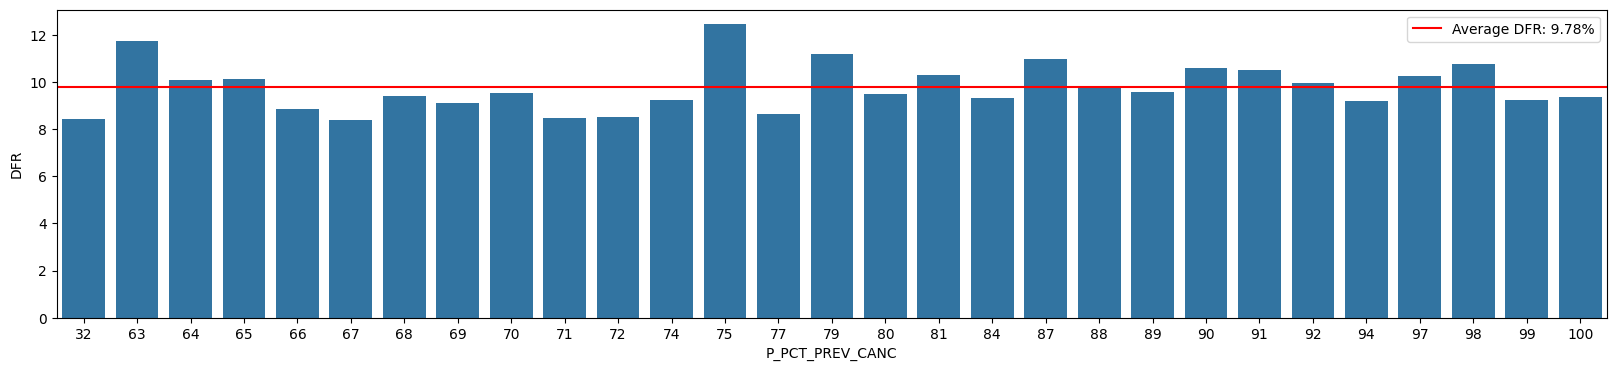

In [632]:
gpv.pctDfr('PCT_PREV_CANC', groupby_flag=True)

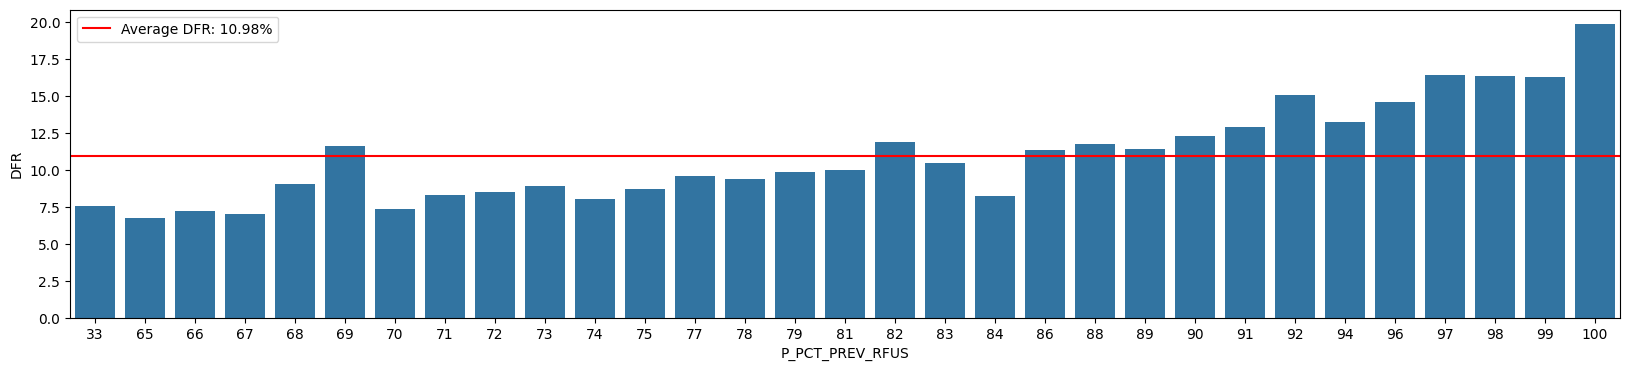

In [634]:
gpv.pctDfr('PCT_PREV_RFUS', groupby_flag=True)

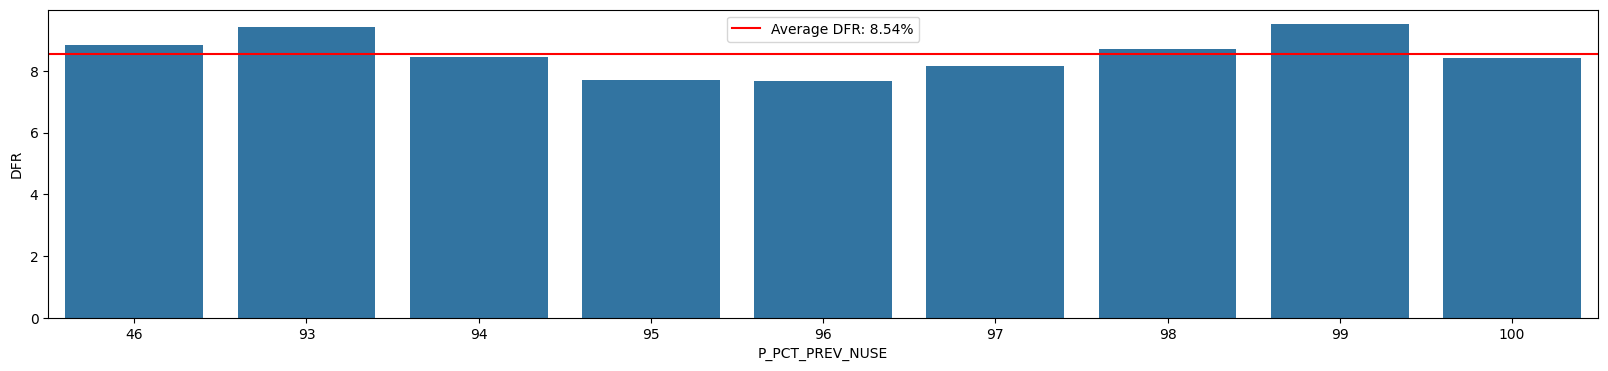

In [636]:
gpv.pctDfr('PCT_PREV_NUSE', groupby_flag=True)

In [640]:
df_prev_app.groupby('NAME_PRODUCT_TYPE')[[pkey]].count()

,SK_ID_CURR
NAME_PRODUCT_TYPE,
XNA,1063666
walk-in,150261
x-sell,456287


Look in term of ratio

In [642]:
df_prev_app = df_prev_app.merge(df_application[[pkey, 'AMT_INCOME_TOTAL', 'TARGET']], on=pkey, how='inner')

# ANNUITY from bureau credit
df_prev_app['PREV_BURDEN_PERCENTAGE'] = df_prev_app['AMT_ANNUITY'] / df_prev_app['AMT_INCOME_TOTAL']
df_prev_app['PREV_RISK_REWARD_RATIO'] = df_prev_app['AMT_CREDIT'] / df_prev_app['AMT_INCOME_TOTAL']

In [53]:
same_cols_prev = list(set(df_prev_app.columns).intersection(set(df_application.columns)))

In [ ]:
df_main = df_application(df_prev_app.drop(columns=same_cols_prev), 
                         on=pkey, how='left')

In [547]:
g = graphVisualizer(df_prev_app)

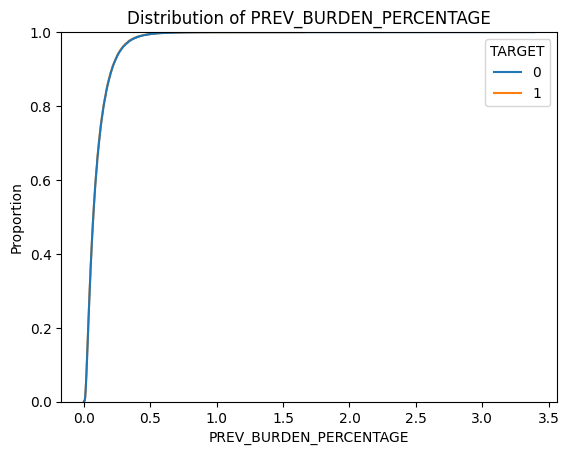

In [550]:
g.cdf('PREV_BURDEN_PERCENTAGE')

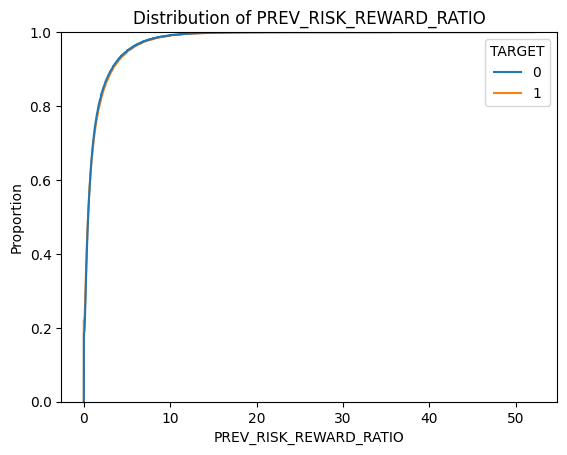

In [549]:
g.cdf('PREV_RISK_REWARD_RATIO')

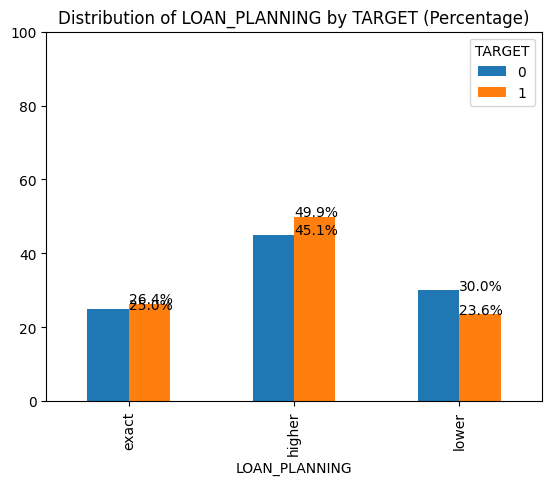

In [552]:
df_prev_app['LOAN_PLANNING'] = df_prev_app.apply(lambda row: _derive_loan_planning(row), axis=1)
g.cat('LOAN_PLANNING')

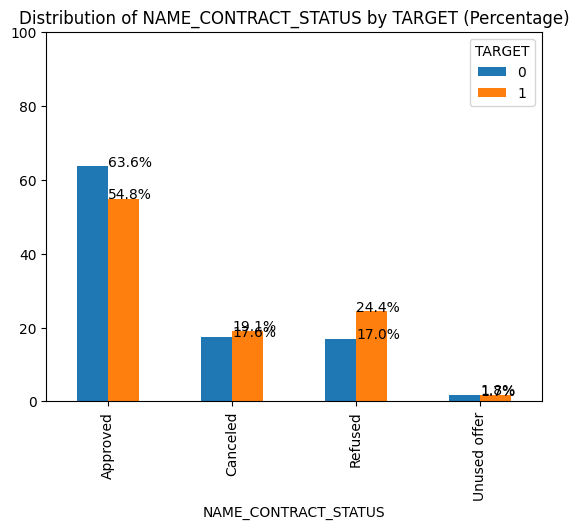

In [555]:
g.cat('NAME_CONTRACT_STATUS')

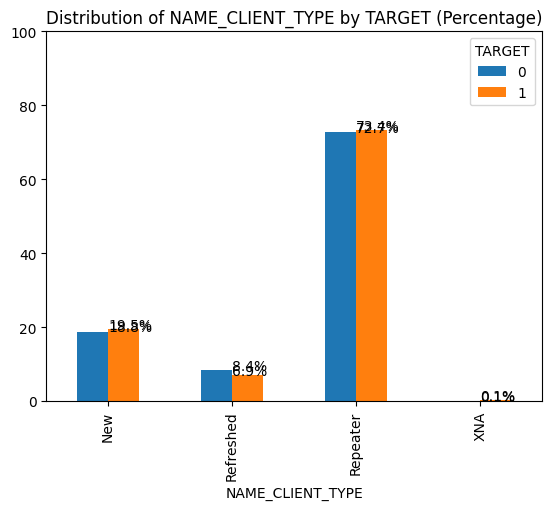

In [557]:
g.cat('NAME_CLIENT_TYPE')

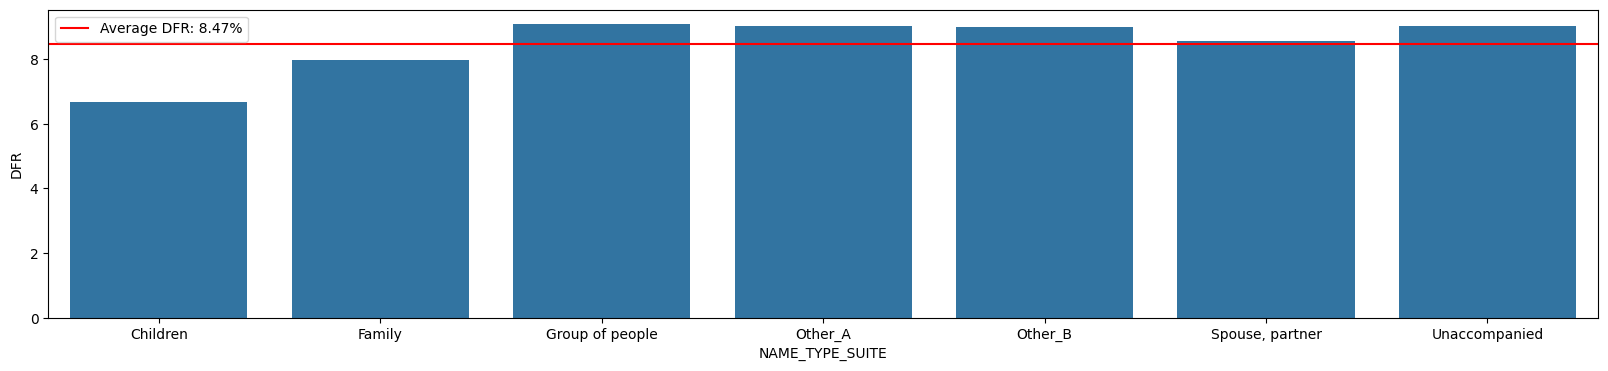

In [562]:
g.pctDfr('NAME_TYPE_SUITE', groupby_flag=False)

In [571]:
df_prev_app.groupby(['FLAG_LAST_APPL_PER_CONTRACT'])[[tg]].count()

,TARGET
FLAG_LAST_APPL_PER_CONTRACT,
N,6186
Y,1133932


In [645]:
df_prev_app[df_prev_app[pkey] == 185661]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INCOME_TOTAL,TARGET,PREV_BURDEN_PERCENTAGE,PREV_RISK_REWARD_RATIO
197,2770539,185661,Revolving loans,6750.000,0.0,180000.0,NaN,NaN,THURSDAY,11,N,0,NaN,NaN,NaN,XAP,Refused,-2621,XNA,XNA,NaN,Repeater,XNA,Cards,x-sell,Country-wide,2024,Consumer electronics,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN,225000.0,0,0.030000,0.80000
90136,1340667,185661,Consumer loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,15,Y,1,NaN,NaN,NaN,XAP,Canceled,-509,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,POS other with interest,NaN,NaN,NaN,NaN,NaN,NaN,225000.0,0,NaN,0.00000
112221,2046119,185661,Consumer loans,19172.925,425592.0,425592.0,0.0,425592.0,TUESDAY,8,Y,1,0.000000,NaN,NaN,XAP,Approved,-908,Cash through the bank,XAP,Unaccompanied,Repeater,Audio/Video,POS,XNA,Country-wide,1200,Consumer electronics,24.0,low_action,POS household without interest,NaN,NaN,NaN,NaN,NaN,NaN,225000.0,0,0.085213,1.89152
155679,1546641,185661,Consumer loans,6563.835,131521.5,140854.5,13945.5,131521.5,FRIDAY,12,Y,1,0.098113,NaN,NaN,XAP,Approved,-2690,Cash through the bank,XAP,Unaccompanied,Repeater,Audio/Video,POS,XNA,Country-wide,-1,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-2659.0,-1969.0,-1999.0,-1995.0,1.0,225000.0,0,0.029173,0.62602
238315,2318645,185661,Consumer loans,27447.255,258039.0,247050.0,25807.5,258039.0,THURSDAY,9,Y,1,0.103009,NaN,NaN,XAP,Approved,-1963,Cash through the bank,XAP,"Spouse, partner",Repeater,Construction Materials,POS,XNA,Stone,30,Construction,10.0,low_normal,POS industry with interest,365243.0,-1926.0,-1656.0,-1716.0,-1708.0,0.0,225000.0,0,0.121988,1.09800
243052,2256311,185661,Cash loans,45517.815,1129500.0,1344294.0,NaN,1129500.0,TUESDAY,15,Y,1,NaN,NaN,NaN,XNA,Approved,-509,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,54.0,low_normal,Cash X-Sell: low,365243.0,-479.0,1111.0,365243.0,365243.0,1.0,225000.0,0,0.202301,5.97464
830107,2229583,185661,Revolving loans,6750.000,0.0,135000.0,NaN,NaN,THURSDAY,12,Y,1,NaN,NaN,NaN,XAP,Approved,-2621,XNA,XAP,NaN,Repeater,XNA,Cards,x-sell,Country-wide,2024,Consumer electronics,0.0,XNA,Card Street,-2620.0,-2564.0,365243.0,-1651.0,-19.0,0.0,225000.0,0,0.030000,0.60000
1020706,2235905,185661,Consumer loans,19275.075,425592.0,425592.0,0.0,425592.0,TUESDAY,10,Y,1,0.000000,NaN,NaN,XAP,Approved,-908,Cash through the bank,XAP,Unaccompanied,Repeater,Audio/Video,POS,XNA,Country-wide,1200,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-877.0,-187.0,-487.0,-483.0,0.0,225000.0,0,0.085667,1.89152
1097376,2306609,185661,Cash loans,55472.535,1147500.0,1230808.5,NaN,1147500.0,SATURDAY,8,Y,1,NaN,NaN,NaN,XNA,Approved,-862,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,30.0,low_normal,Cash X-Sell: low,365243.0,-832.0,38.0,-172.0,-168.0,1.0,225000.0,0,0.246545,5.47026


Previous money behavior -> Tracking -> Predict default?

# Bureau

In [788]:
df_bureau = pipeline.importData('bureau')

In [683]:
n_bureau = df_bureau[df_bureau[pkey].isin(df_application[pkey].unique())][pkey].nunique()
n_all = df_application.shape[0]

print('Have previous application data:', f'{round(n_prev_app * 100 / n_all, 2)}%')

Have previous application data: 94.58%


In [679]:
bureau_metada['credit_info']

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [685]:
df_bureau.SK_ID_CURR.nunique()

305811

Note:
* CREDIT_TYPE
* CREDIT_DAY_OVERDUE

In [687]:
df_bureau[df_bureau[pkey] == 100002]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
675684,100002,6158904,Closed,currency 1,-1125,0,-1038.0,-1038.0,NaN,0,40761.000,NaN,NaN,0.0,Credit card,-1038,0.0
675685,100002,6158905,Closed,currency 1,-476,0,NaN,-48.0,NaN,0,0.000,0.0,NaN,0.0,Credit card,-47,NaN
675686,100002,6158906,Closed,currency 1,-1437,0,-1072.0,-1185.0,0.000,0,135000.000,0.0,0.000,0.0,Consumer credit,-1185,0.0
675687,100002,6158907,Closed,currency 1,-1121,0,-911.0,-911.0,3321.000,0,19071.000,NaN,NaN,0.0,Consumer credit,-906,0.0
675688,100002,6158908,Closed,currency 1,-645,0,85.0,-36.0,5043.645,0,120735.000,0.0,0.000,0.0,Consumer credit,-34,0.0
675689,100002,6158909,Active,currency 1,-103,0,NaN,NaN,40.500,0,31988.565,0.0,31988.565,0.0,Credit card,-24,0.0
1337779,100002,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.0,0.000,0.0,Consumer credit,-7,0.0
1486113,100002,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.000,0,67500.000,NaN,NaN,0.0,Credit card,-758,0.0


In [721]:
df_bureau['DPD30_FLAG'] = df_bureau['CREDIT_DAY_OVERDUE'].apply(lambda dpd: 1 if 60 > dpd >= 30 else 0)
df_bureau['DPD60_FLAG'] = df_bureau['CREDIT_DAY_OVERDUE'].apply(lambda dpd: 1 if dpd >= 60 else 0)

In [724]:
df_bureau = df_bureau.merge(df_application[[pkey, tg]], on=pkey, how='inner')

In [725]:
gbr = graphVisualizer(df_bureau)

In [728]:
df_bureau.groupby(['DPD30_FLAG'])[[pkey]].count()

,SK_ID_CURR
DPD30_FLAG,
0,1207996
1,640


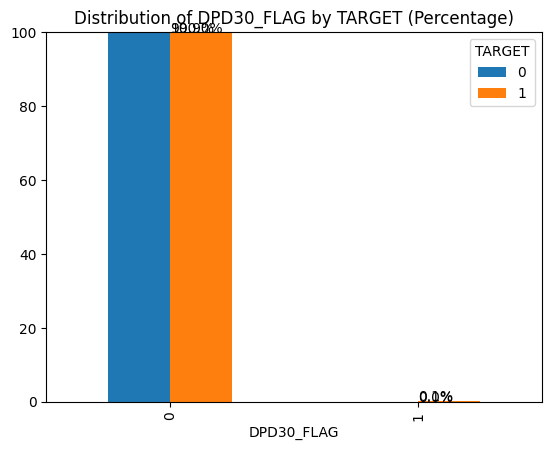

In [726]:
gbr.cat('DPD30_FLAG')

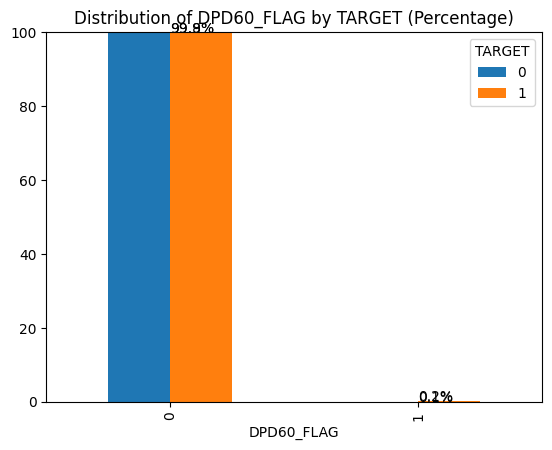

In [727]:
gbr.cat('DPD60_FLAG')

## Bureau Balance

In [953]:
df_bureau_bal = pipeline.importData('bureau_bal')

Status of Credit Bureau loan during the month
    
* C means closed, 
* X means status unknown, 
* 0 means no DPD, 
* 1 means maximal did during month between 1-30, 
* 2 means DPD 31-60,… 
* 3 61-90
* 4 91-120
* 5 means DPD 120+ or sold or written off

In [986]:
df_bureau_bal_agg = df_bureau_bal.pivot_table(index='SK_ID_BUREAU', values='MONTHS_BALANCE', columns='STATUS', aggfunc='min').reset_index()

df_bureau_bal_agg = df_bureau_bal_agg.merge(df_bureau[['SK_ID_CURR', 'SK_ID_BUREAU',
                                                       'CREDIT_ACTIVE', 'CREDIT_TYPE', 'AMT_CREDIT_SUM', 'AMT_ANNUITY']], on='SK_ID_BUREAU', how='inner')
df_bureau_bal_agg = df_bureau_bal_agg.merge(df_application[[pkey, tg]], on=pkey, how='inner')

In [1007]:
df_bureau_bal_agg['CREDIT_TYPE'] = df_bureau_bal_agg['CREDIT_TYPE'].str.replace(" ", "_").str.lower()

In [1018]:
df_bureau_bal_agg['CREDIT_GROUP'] = df_bureau_bal_agg['CREDIT_TYPE'].apply(lambda x: loans_config[x])

In [1008]:
df_bureau_bal_agg[(df_bureau_bal_agg['CREDIT_ACTIVE'] == 'Active') & (df_bureau_bal_agg['2'] < 0)]

,SK_ID_BUREAU,0,1,2,3,4,5,C,X,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_TYPE,AMT_CREDIT_SUM,AMT_ANNUITY,TARGET,30DPD_FLAG,60DPD_FLAG,90DPD_FLAG,120DPD_FLAG,WRITE_OFF_FLAG,DPD_EVER_FLAG
692,5009628,-59.0,-46.0,-38.0,-37.0,-36.0,-35.0,-31.0,NaN,263532,Active,credit_card,135000.0,NaN,1,1,1,1,1,1,1
771,5009749,-15.0,-11.0,-10.0,-8.0,-7.0,-6.0,NaN,NaN,367550,Active,consumer_credit,900000.0,33790.5,1,1,1,1,1,1,1
776,5009754,-36.0,-32.0,-31.0,-29.0,-28.0,-27.0,-11.0,NaN,367550,Active,credit_card,0.0,33790.5,1,1,1,1,1,1,1
1189,5010255,-83.0,-80.0,-76.0,-75.0,-74.0,-73.0,-66.0,NaN,304395,Active,consumer_credit,108810.0,NaN,0,1,1,1,1,1,1
1371,5010538,-19.0,-18.0,-17.0,NaN,NaN,NaN,-14.0,NaN,340593,Active,credit_card,180000.0,0.0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430517,6837264,-22.0,-16.0,-15.0,NaN,NaN,NaN,-10.0,NaN,386651,Active,consumer_credit,206550.0,NaN,0,1,1,0,0,0,0
430675,6837450,-10.0,-8.0,-1.0,0.0,NaN,NaN,NaN,NaN,236596,Active,credit_card,22500.0,19800.0,1,1,1,0,0,0,0
430679,6837454,-34.0,NaN,-30.0,-29.0,-28.0,NaN,-27.0,NaN,243044,Active,credit_card,288000.0,7200.0,0,0,1,1,1,0,0
431246,6839673,-51.0,-44.0,-34.0,NaN,NaN,NaN,NaN,NaN,184626,Active,credit_card,45000.0,4045.5,0,1,1,0,0,0,0


In [1002]:
df_bureau_bal_agg['30DPD_FLAG'] = df_bureau_bal_agg['1'].apply(lambda x: 1 if x < 0 else 0)
df_bureau_bal_agg['60DPD_FLAG'] = df_bureau_bal_agg['2'].apply(lambda x: 1 if x < 0 else 0)
df_bureau_bal_agg['90DPD_FLAG'] = df_bureau_bal_agg['3'].apply(lambda x: 1 if x < 0 else 0)
df_bureau_bal_agg['120DPD_FLAG'] = df_bureau_bal_agg['4'].apply(lambda x: 1 if x < 0 else 0)
df_bureau_bal_agg['WRITE_OFF_FLAG'] = df_bureau_bal_agg['5'].apply(lambda x: 1 if x < 0 else 0)

df_bureau_bal_agg['DPD_EVER_FLAG'] = df_bureau_bal_agg.apply(lambda r: 1 if r['1']+r['2']+r['3']+r['4']+r['5'] < 0 else 0, axis=1)

In [1003]:
gdbd = graphVisualizer(df_bureau_bal_agg)

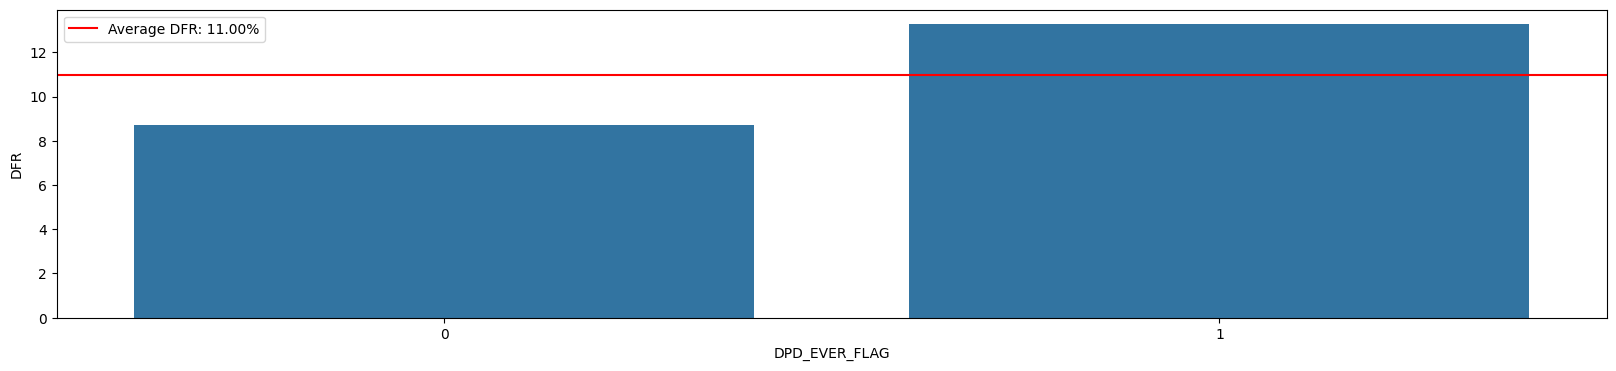

In [1006]:
gdbd.pctDfr('DPD_EVER_FLAG', groupby_flag=False)

In [1036]:
x = df_bureau_bal_agg.pivot_table(index=[pkey, tg], columns='CREDIT_GROUP', values='DPD_EVER_FLAG', aggfunc='sum').reset_index()

In [1033]:
df_bureau_bal_agg.CREDIT_GROUP.unique()

array(['personal_need_loan', 'real_estate_loan', 'unknown',
       'business_loan'], dtype=object)

In [1037]:
gx = graphVisualizer(x)

In [1040]:
x.groupby('personal_need_loan').count()

CREDIT_GROUP,SK_ID_CURR,TARGET,business_loan,real_estate_loan,unknown
personal_need_loan,,,,,
0.0,74513,74513,470,4699,296
1.0,739,739,12,38,7
2.0,171,171,4,10,0
3.0,81,81,1,3,0
4.0,43,43,0,0,0
5.0,20,20,0,0,0
6.0,6,6,0,2,0
7.0,5,5,0,0,0
8.0,3,3,0,0,0


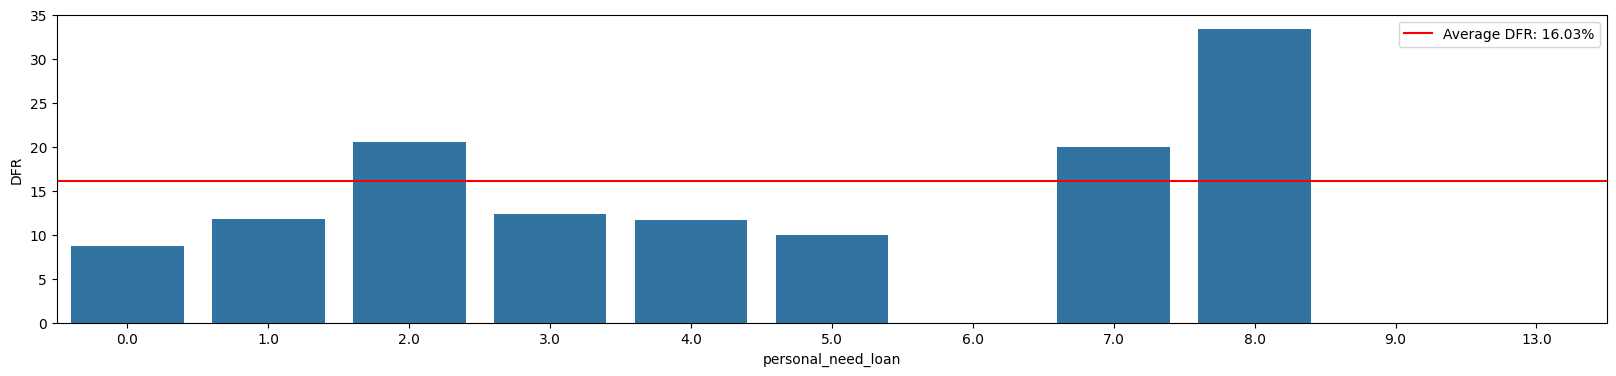

In [1039]:
gx.pctDfr('personal_need_loan', groupby_flag=False)

# Credit Card

In [733]:
df_cc = pipeline.importData('cc')

* cc aging
* nbr cc
* avg spending

In [784]:
df_bureau_cc = df_bureau[df_bureau['CREDIT_TYPE']=='Credit card'].pivot_table(index=pkey, columns='CREDIT_ACTIVE', values='SK_ID_BUREAU', aggfunc='count').fillna(0).reset_index()

In [794]:
df_bureau_cc = df_bureau_cc.merge(df_cc[df_cc['NAME_CONTRACT_STATUS'] == 'Active'].pivot_table(index=pkey, values='SK_ID_PREV', aggfunc='nunique').reset_index(),
                                on=pkey,
                                how='right')

From all of the credit cards that customer posess, how many of them are "Home Lone", and how many of them are not, `CNT_OTH_CC`.

In [795]:
df_bureau_cc.columns = [pkey, 'CNT_TOT_CC_ACTIVE', 'CNT_TOT_CC_BAD', 'CNT_TOT_CC_CL', 'CNT_TOT_CC_SOLD', 'CNT_HML_CC_ACTIVE']
df_bureau_cc = df_bureau_cc.merge(df_application[[pkey, 'TARGET']], on =pkey, how='right').reset_index().fillna(0)

In [796]:
df_bureau_cc['CNT_OTH_CC'] = df_bureau_cc['CNT_TOT_CC_ACTIVE'] - df_bureau_cc['CNT_HML_CC_ACTIVE']

What if the customer home loan has is poor quality
* No bad debt

In [797]:
gcc = graphVisualizer(df_bureau_cc)

In [802]:
df_bureau_cc.groupby('CNT_OTH_CC')[pkey].count()

CNT_OTH_CC
-2.0        191
-1.0      34411
 0.0     199700
 1.0      10132
 2.0       4259
 3.0       1939
 4.0        800
 5.0        371
 6.0        181
 7.0         73
 8.0         40
 9.0         24
 10.0         7
 11.0         5
 12.0         1
 14.0         2
 16.0         1
Name: SK_ID_CURR, dtype: int64

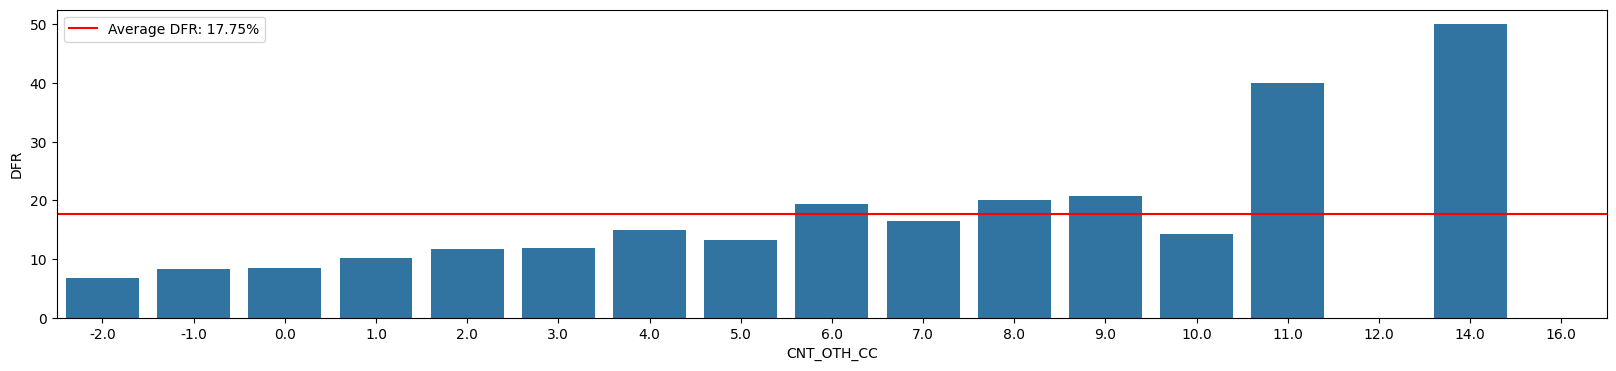

In [799]:
gcc.pctDfr('CNT_OTH_CC', groupby_flag=False)

In [804]:
df_bureau_cc.groupby('CNT_HML_CC_ACTIVE')[pkey].count()

CNT_HML_CC_ACTIVE
0.0    177961
1.0     73724
2.0       449
3.0         3
Name: SK_ID_CURR, dtype: int64

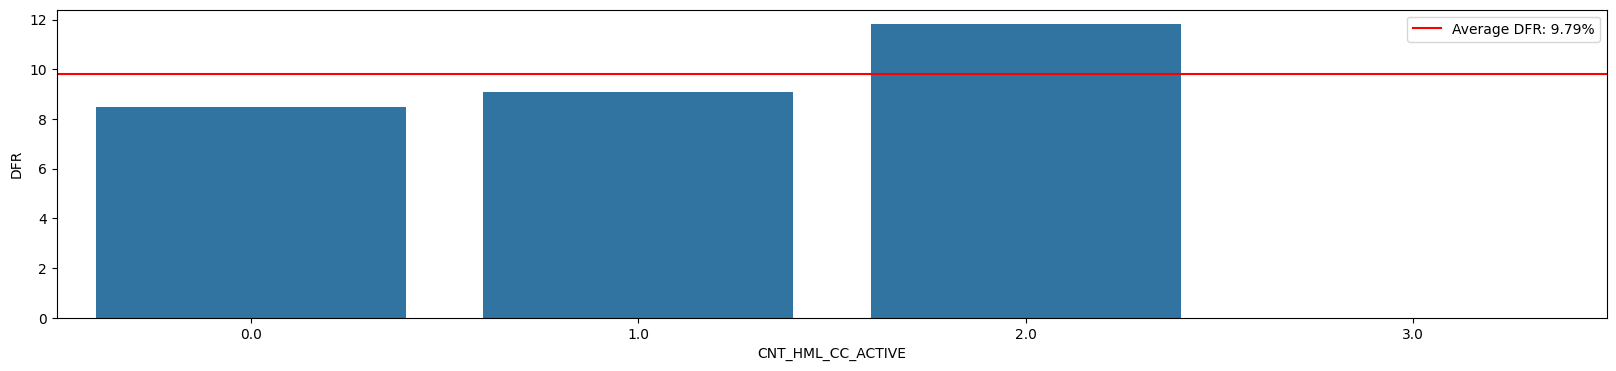

In [800]:
gcc.pctDfr('CNT_HML_CC_ACTIVE', groupby_flag=False)

In [817]:
df_cc_behavior = df_cc.pivot_table(index=pkey, values='AMT_TOTAL_RECEIVABLE', aggfunc=['mean', 'median', 'min', 'max', np.std]).reset_index().round(2)

C:\Users\SirabhopSaengumyoun\AppData\Local\Temp\ipykernel_38128\3696556722.py:1: FutureWarning: The provided callable <function std at 0x000001E77E1FA5C0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df_cc_behavior = df_cc.pivot_table(index=pkey, values='AMT_TOTAL_RECEIVABLE', aggfunc=['mean', 'median', 'min', 'max', np.std]).reset_index().round(2)


In [ ]:
df_cc_behavior.columns = [pkey, 'AVG_CC_SPD', 'MED_CC_SPD', 'MIN_CC_SPD', 'MAX_CC_SPD', 'SD_CC_SPD']

In [820]:
df_cc_behavior = df_cc_behavior.merge(df_application[[pkey, 'TARGET']], on=pkey, how='inner')

In [822]:
gccb = graphVisualizer(df_cc_behavior)

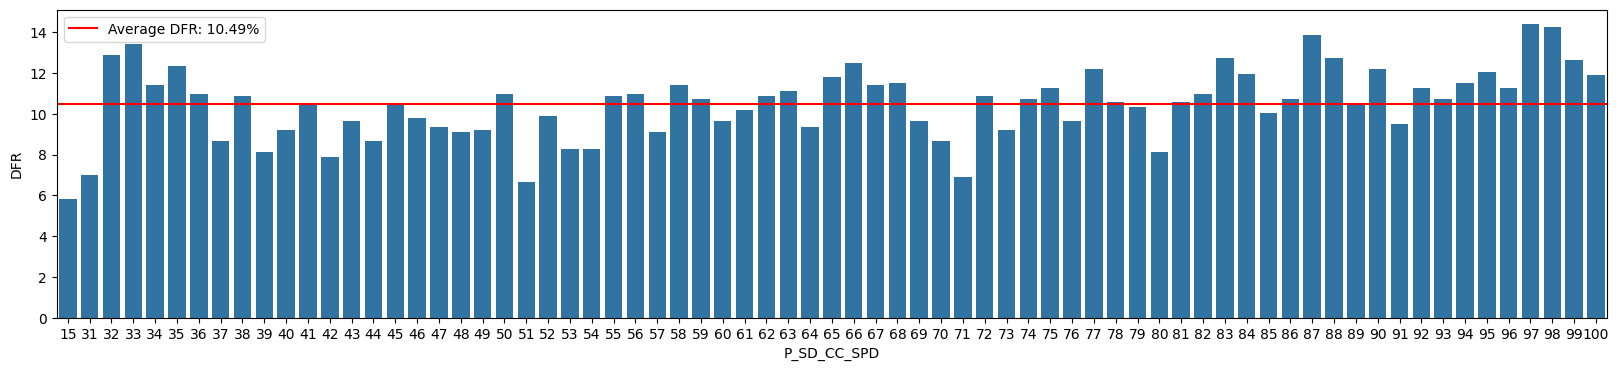

In [823]:
gccb.pctDfr('SD_CC_SPD')

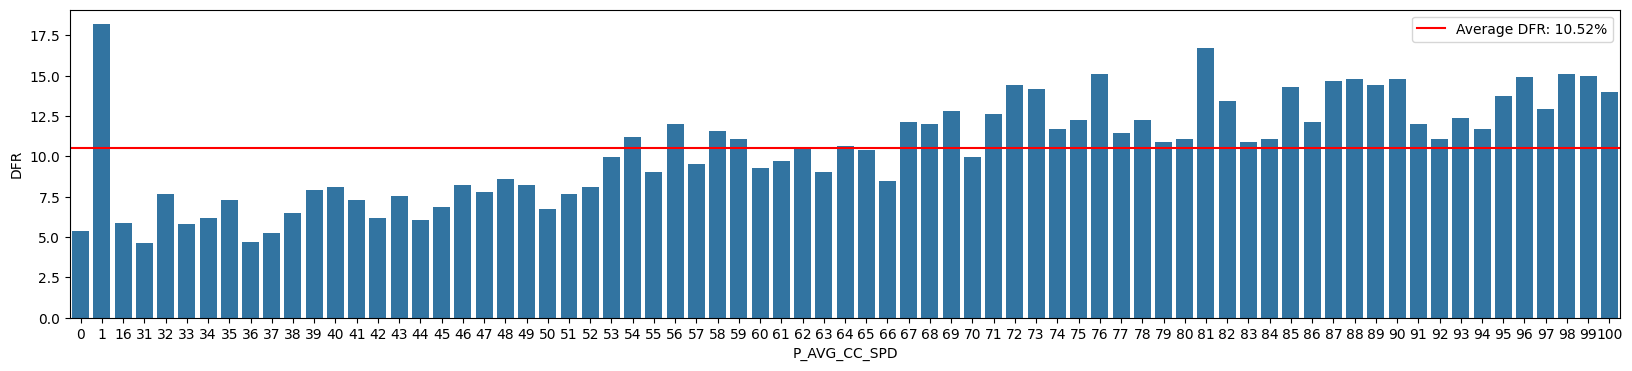

In [824]:
gccb.pctDfr('AVG_CC_SPD')

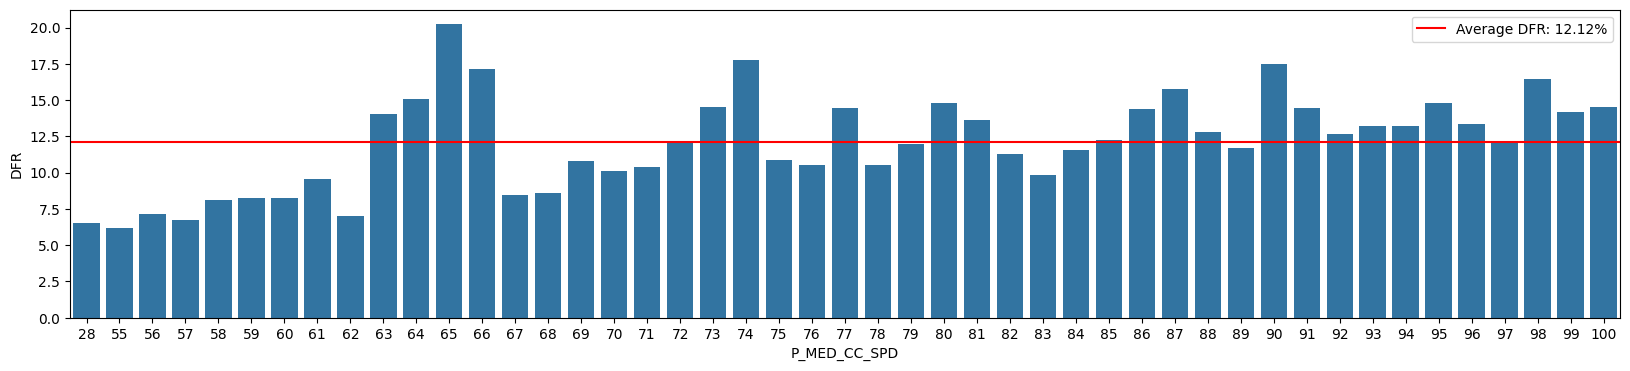

In [825]:
gccb.pctDfr('MED_CC_SPD')

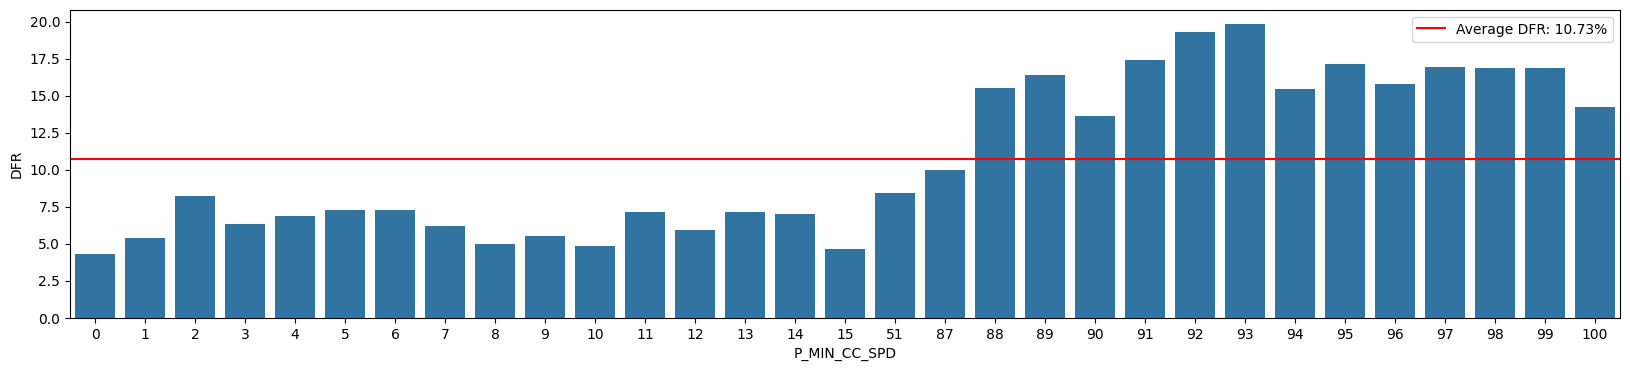

In [826]:
gccb.pctDfr('MIN_CC_SPD')

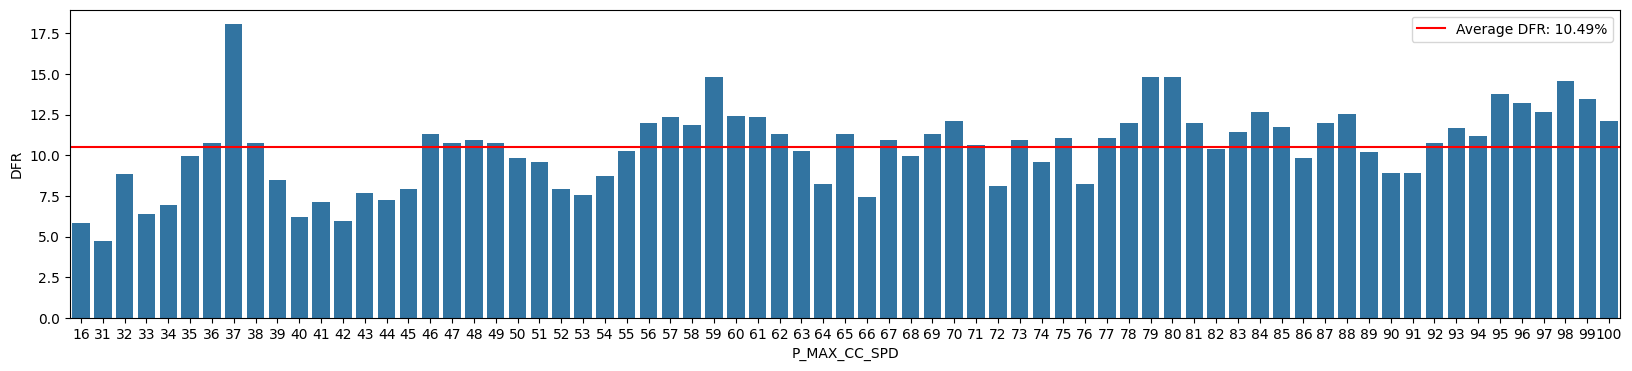

In [827]:
gccb.pctDfr('MAX_CC_SPD')

In [836]:
df_cc_aging = df_cc.pivot_table(index=pkey, values='MONTHS_BALANCE', aggfunc='min').reset_index()
df_cc_aging = df_cc_aging.merge(df_application[[pkey, 'TARGET']], on=pkey, how='inner')

In [840]:
df_cc_aging['MONTHS_BALANCE'] = -1 * df_cc_aging['MONTHS_BALANCE']

In [841]:
gcca = graphVisualizer(df_cc_aging)

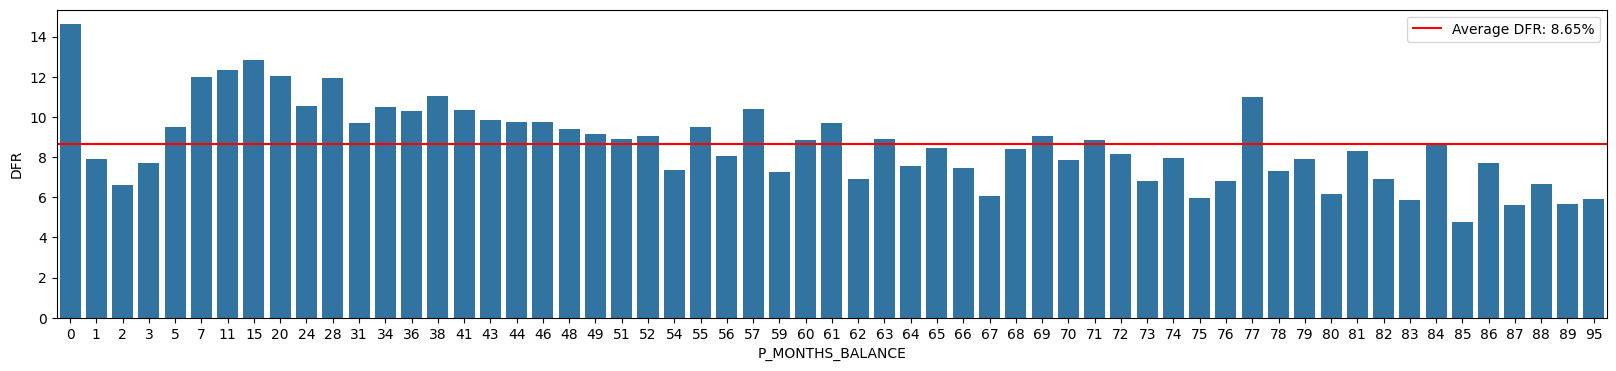

In [842]:
gcca.pctDfr('MONTHS_BALANCE')

## Installment

In [844]:
df_inst = pipeline.importData('inst')

In [866]:
df_inst_cc = df_inst[df_inst['NUM_INSTALMENT_VERSION'] == 0].reset_index(drop=True)

In [867]:
df_inst_cc['AMT_GAP_INST_PYMT'] = df_inst_cc['AMT_INSTALMENT'] -  df_inst_cc['AMT_PAYMENT']

In [869]:
df_agg_inst_cc = df_inst_cc.pivot_table(index='SK_ID_CURR', values = ['NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT',	'AMT_PAYMENT', 'AMT_GAP_INST_PYMT'], 
                                        aggfunc=['min','max','median','mean', np.std]).reset_index()

C:\Users\SirabhopSaengumyoun\AppData\Local\Temp\ipykernel_38128\3504439771.py:1: FutureWarning: The provided callable <function std at 0x000001E77E1FA5C0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df_agg_inst_cc = df_inst_cc.pivot_table(index='SK_ID_CURR', values = ['NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT',	'AMT_PAYMENT', 'AMT_GAP_INST_PYMT'],


In [871]:
df_agg_inst_cc.columns = [
    'SK_ID_CURR', 
    'MIN_GAP', 'MIN_INST', 'MIN_PMNT', 'MIN_INST_NBR',
    'MAX_GAP', 'MAX_INST', 'MAX_PMNT', 'MAX_INST_NBR',
    'MED_GAP', 'MED_INST', 'MED_PMNT', 'MED_INST_NBR',
    'AVG_GAP', 'AVG_INST', 'AVG_PMNT', 'AVG_INST_NBR',
    'SD_GAP', 'SD_INST', 'SD_PMNT', 'SD_INST_NBR',

]

In [873]:
df_agg_inst_cc = df_agg_inst_cc.merge(
    df_application[[pkey, tg]], on=pkey, how='right'
)

In [875]:
ginst = graphVisualizer(df_agg_inst_cc)

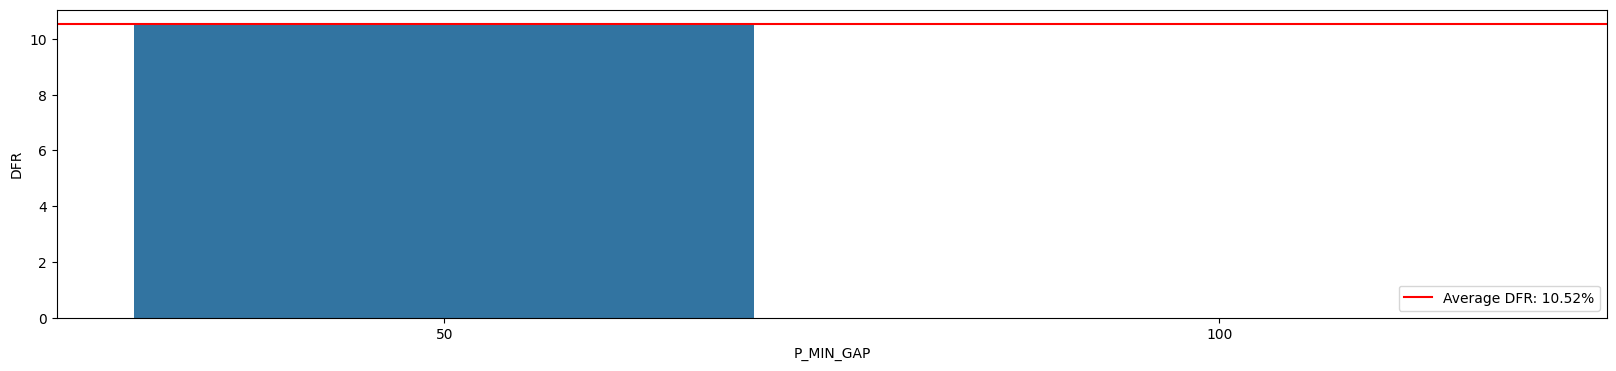

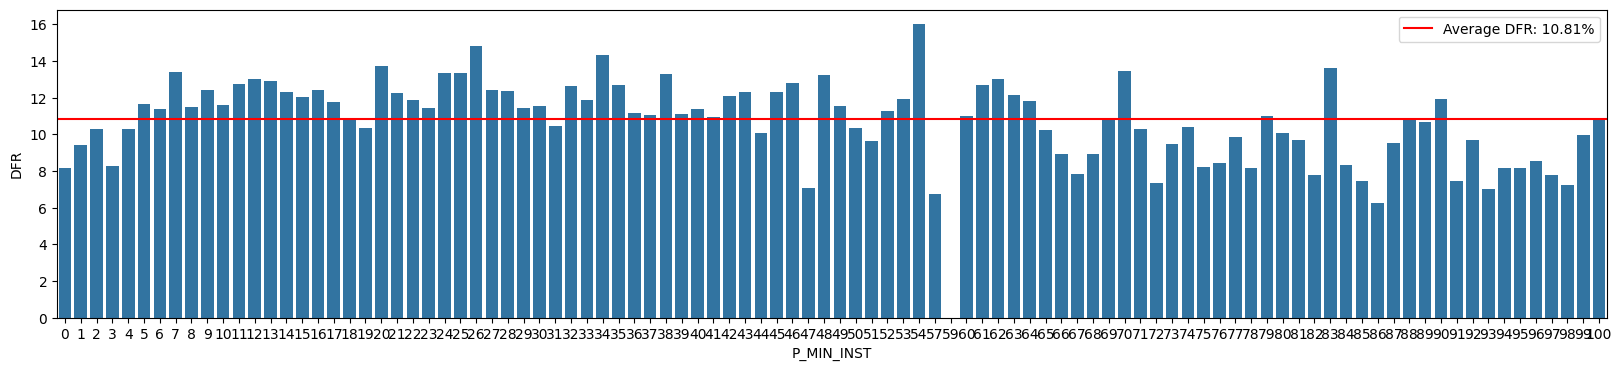

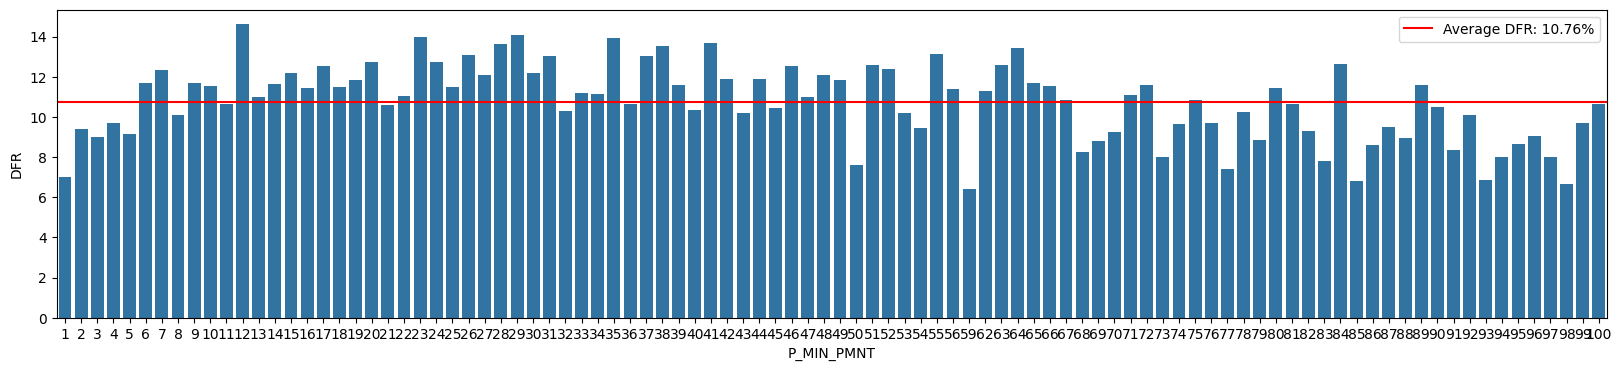

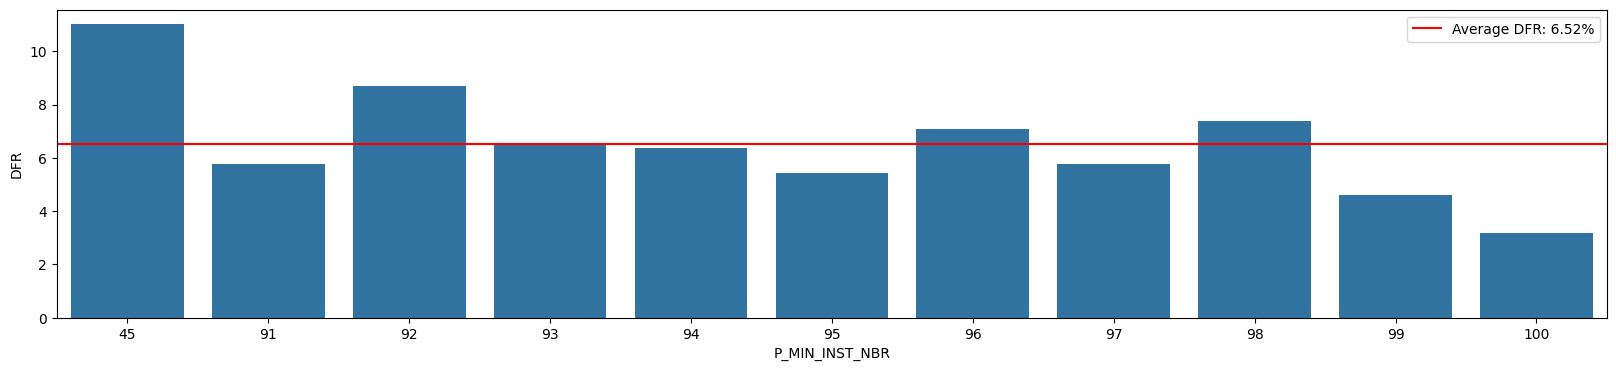

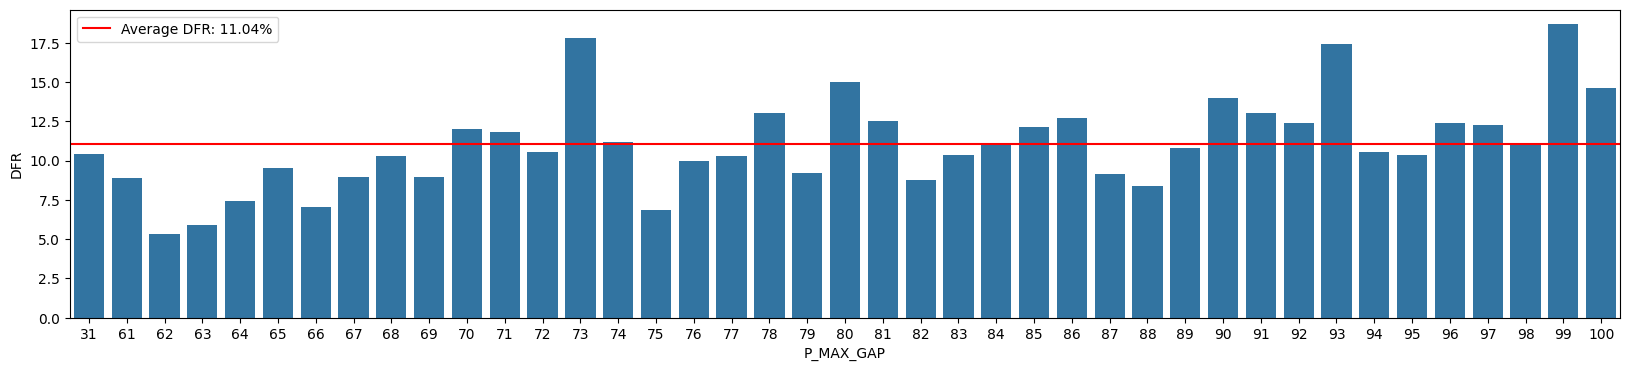

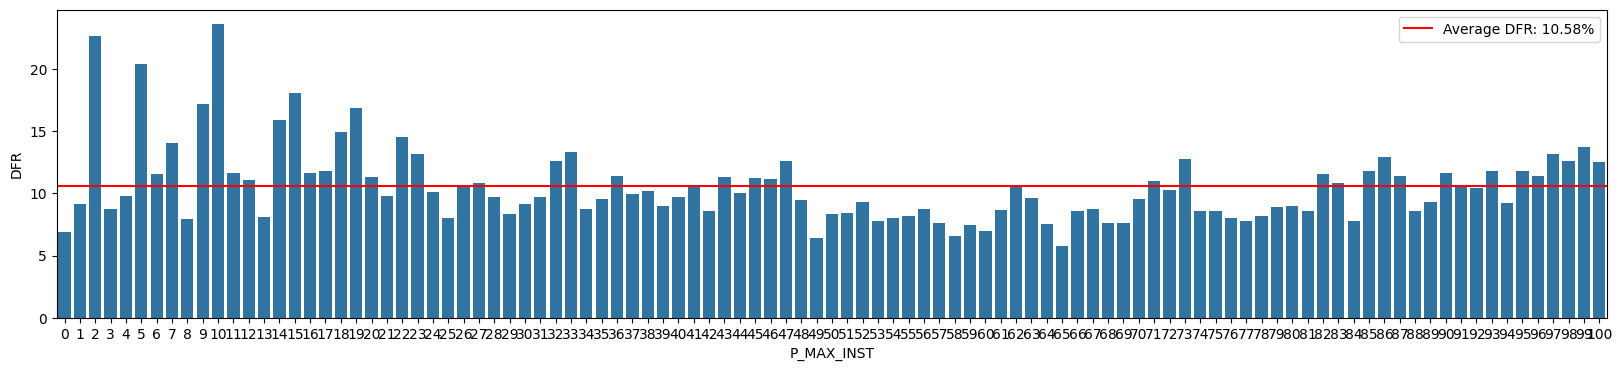

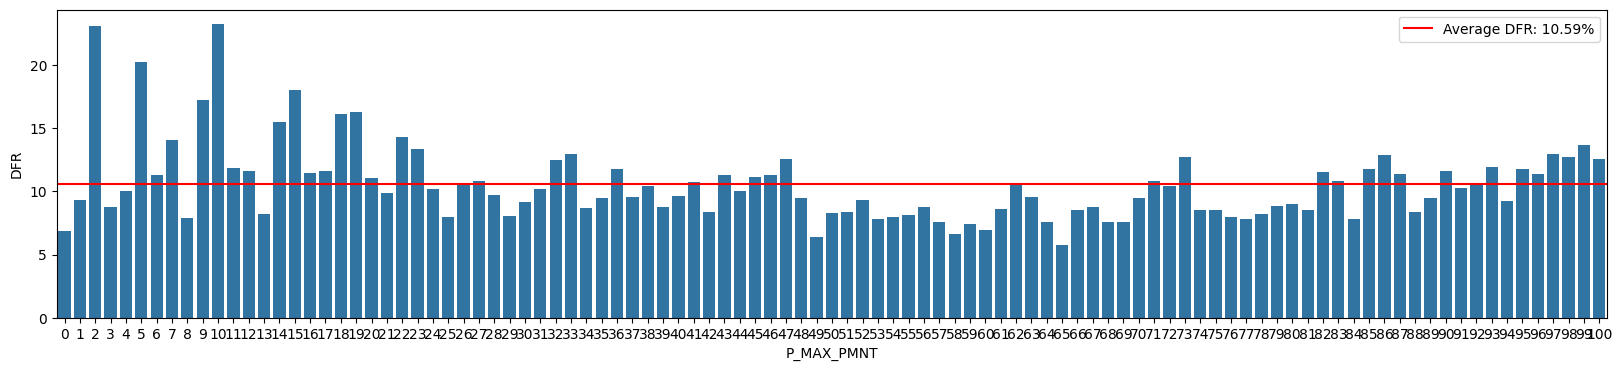

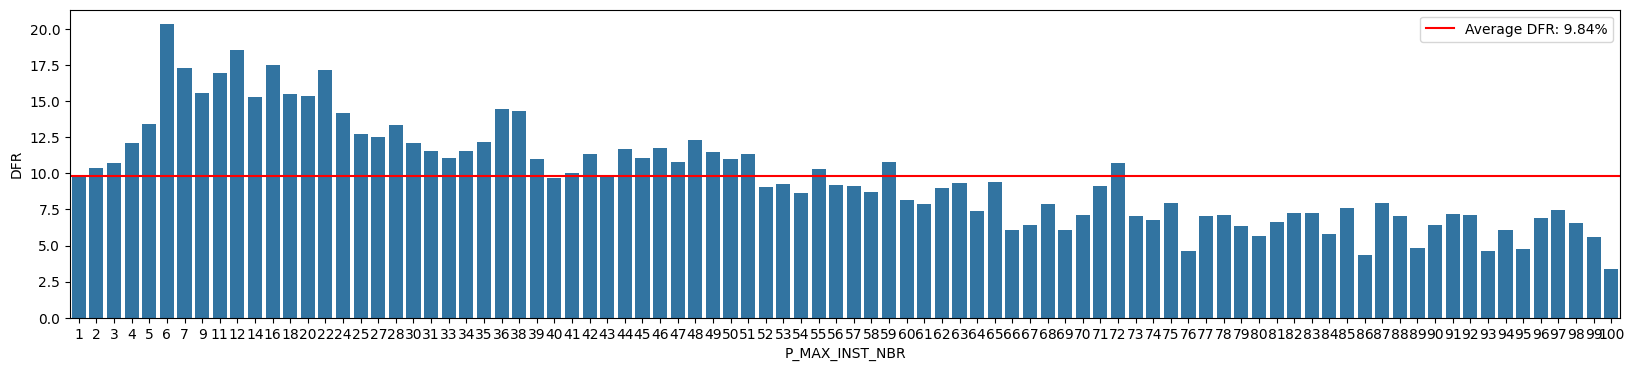

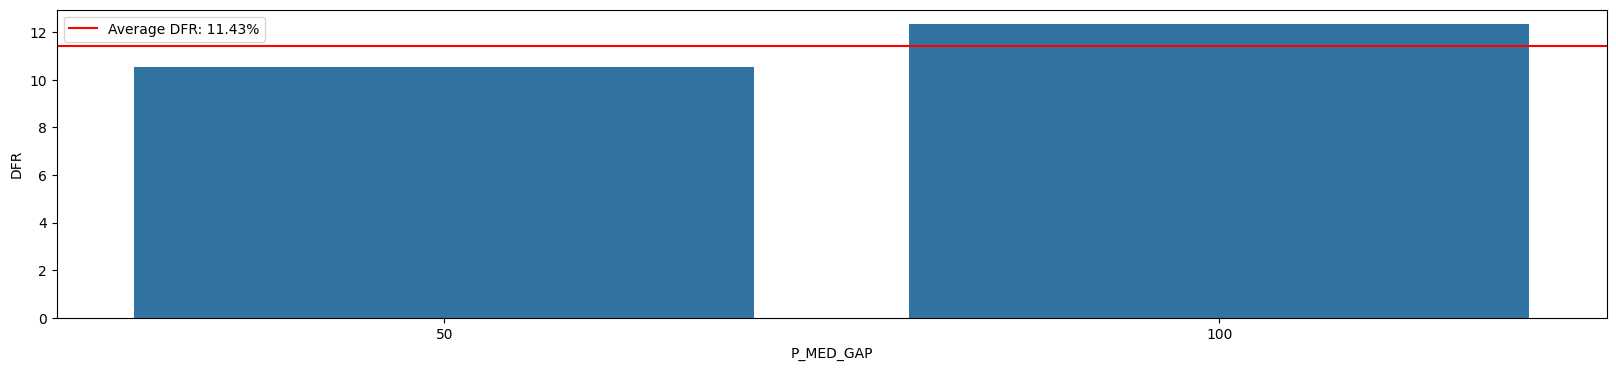

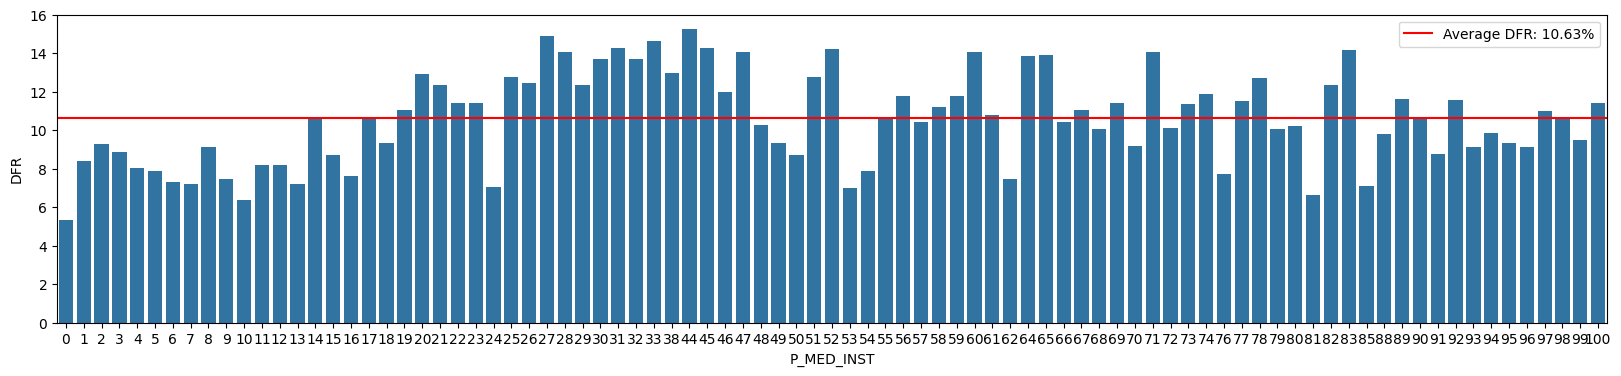

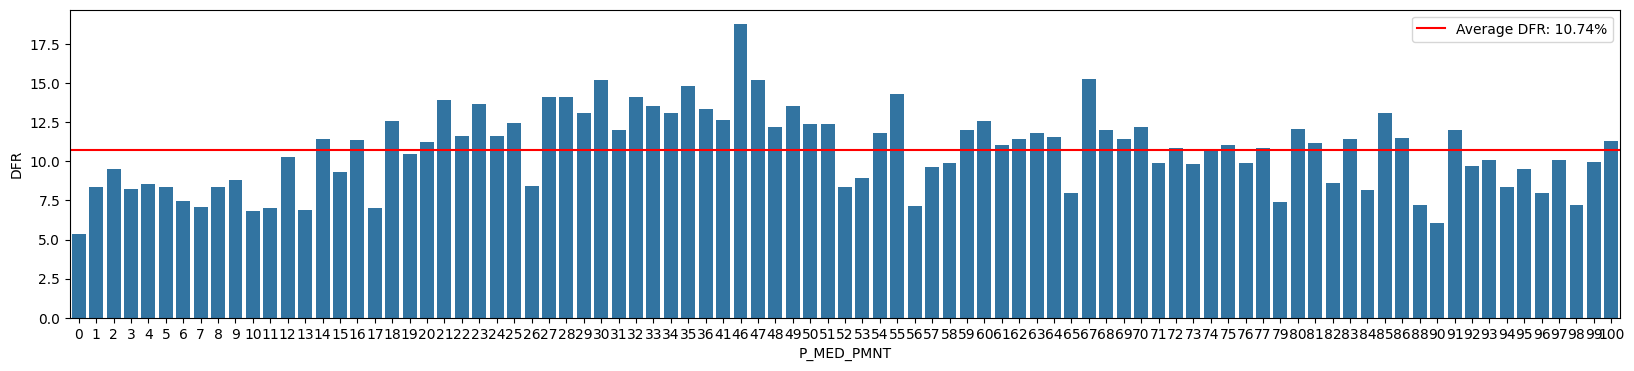

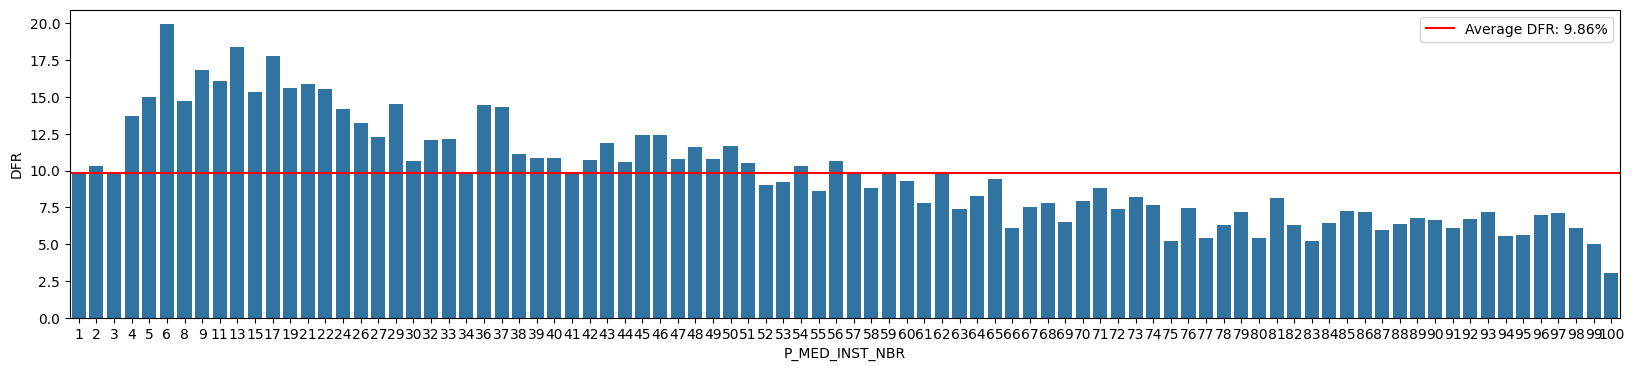

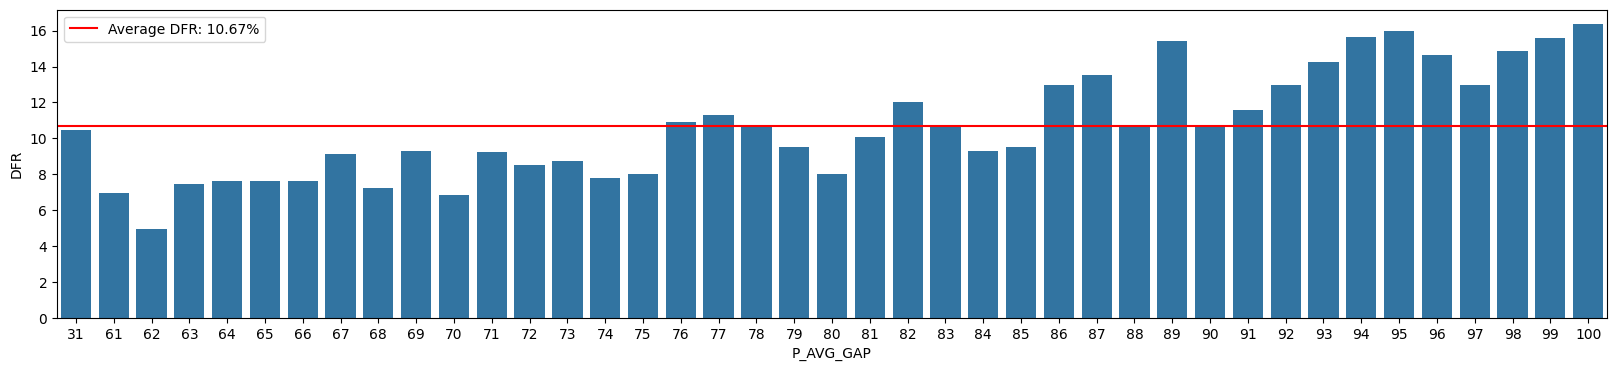

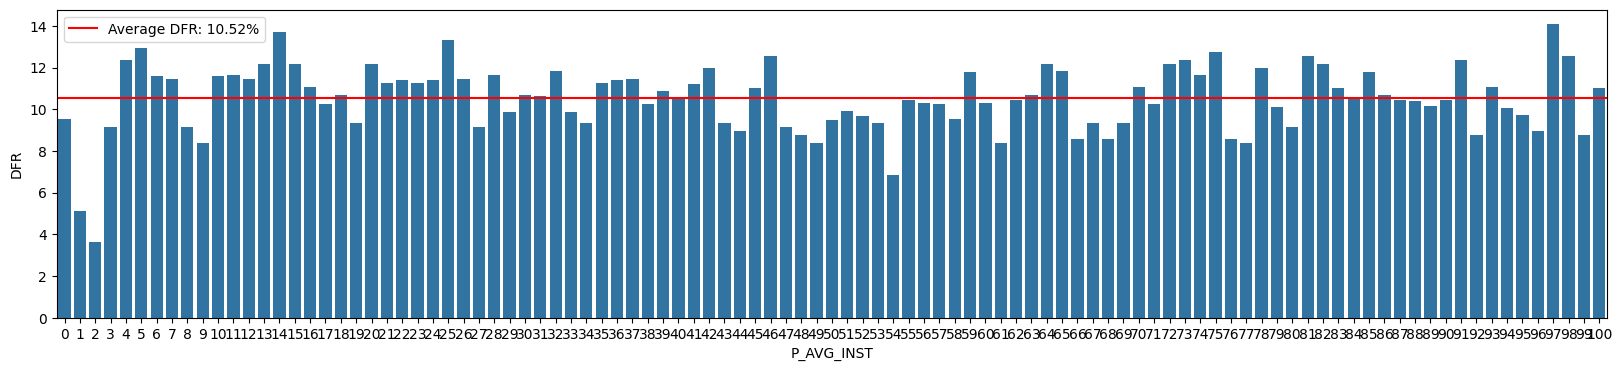

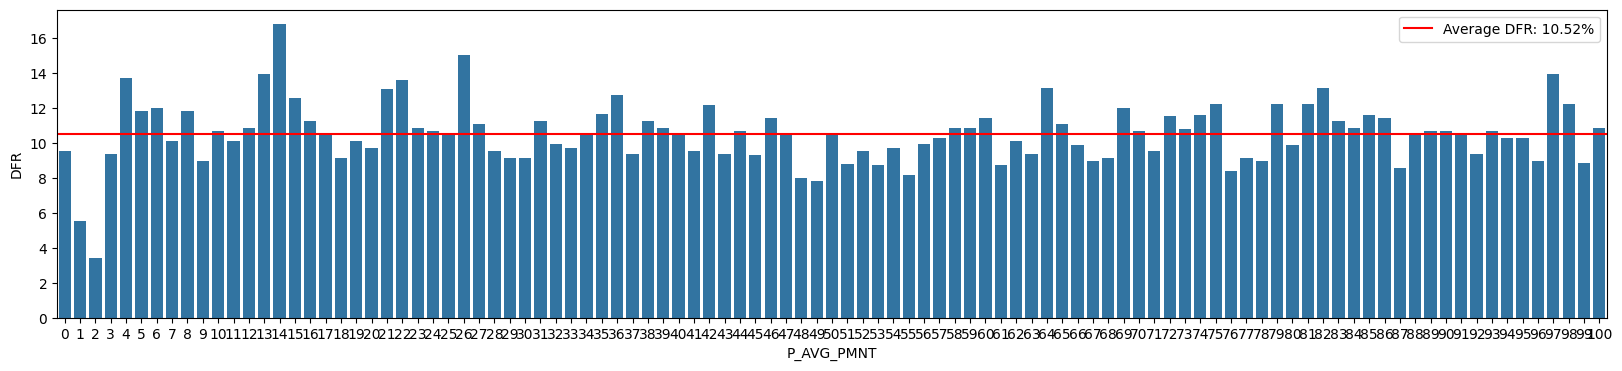

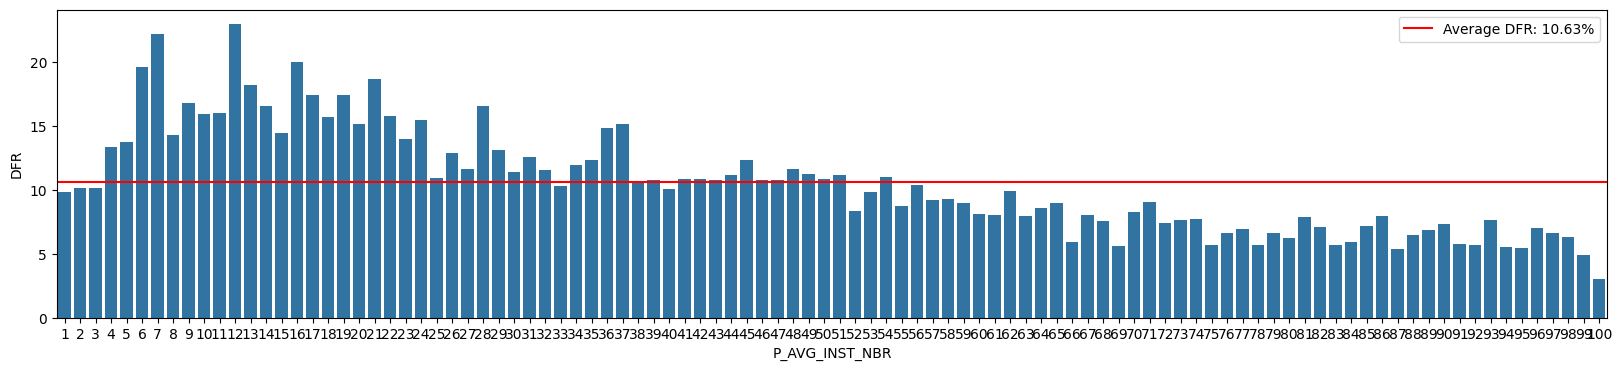

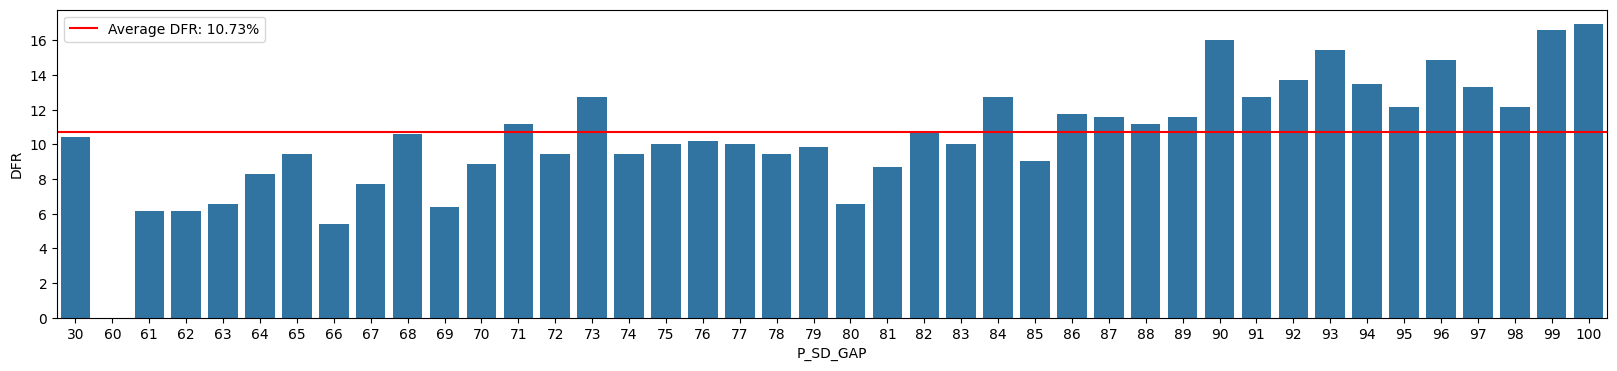

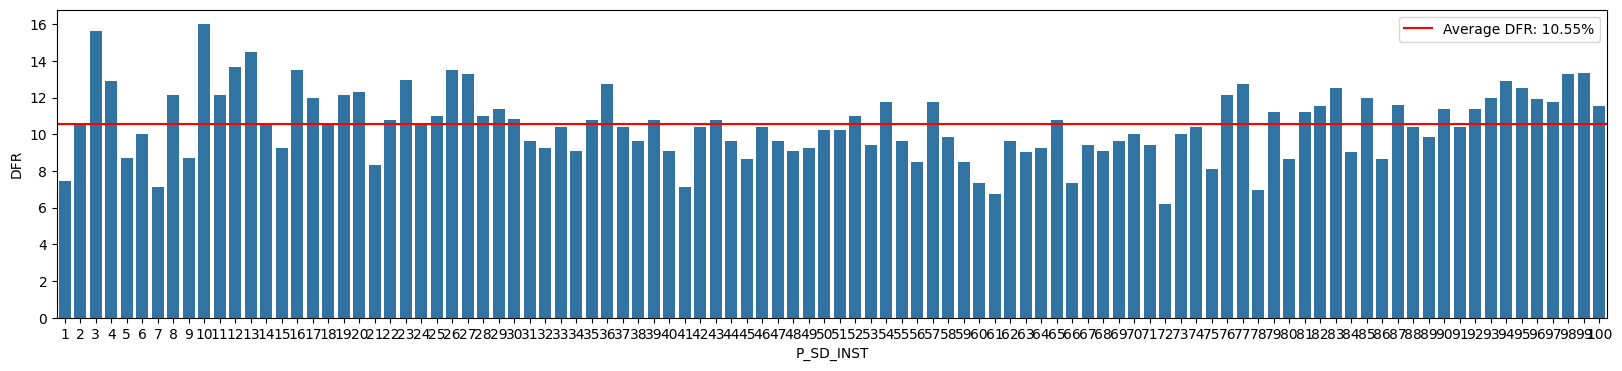

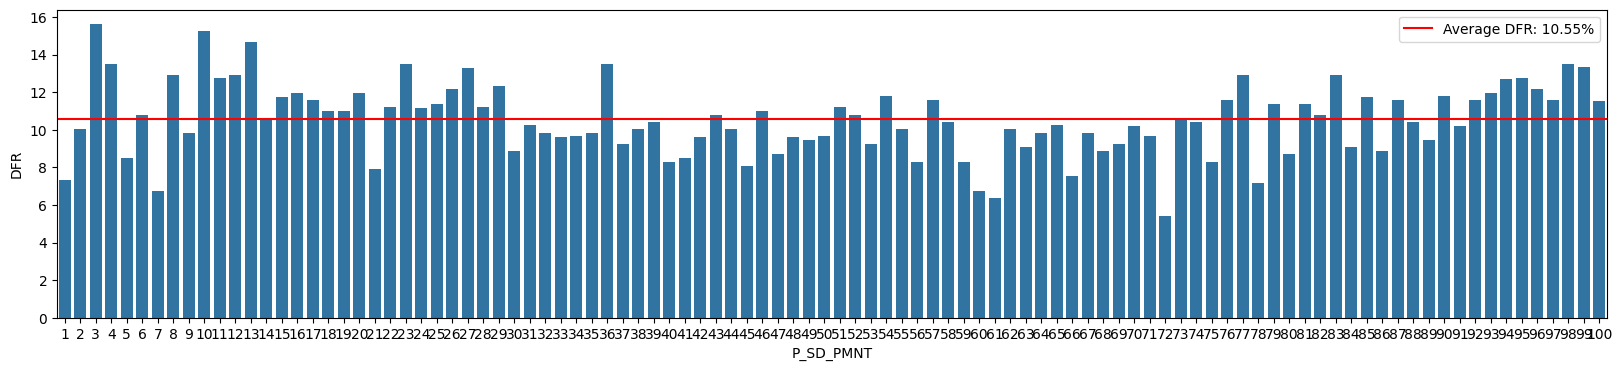

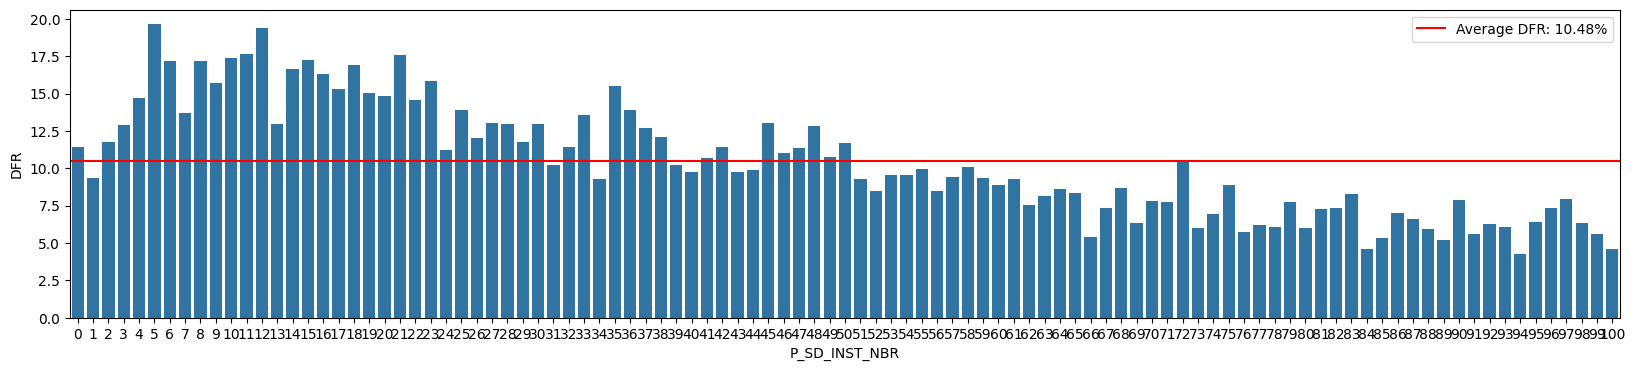

In [878]:
for col in list(df_agg_inst_cc.columns):
    if col not in [pkey, tg]:
        ginst.pctDfr(col)

In [884]:
df_cc_behavior = df_cc_behavior.merge(df_agg_inst_cc.drop(columns=tg).reset_index(drop=True), on=pkey, how='inner')

In [888]:
df_cc_behavior = df_cc_behavior.dropna()

In [894]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [897]:
df_cc_behavior['SCL_INST_NBR'] = scaler.fit_transform(df_cc_behavior[['MAX_INST_NBR']])
df_cc_behavior['SCL_MED_CC_SPD'] = scaler.fit_transform(df_cc_behavior[['MED_CC_SPD']])

In [902]:
df_cc_behavior['QDR_INST_NBR'] = df_cc_behavior['SCL_INST_NBR'].apply(lambda x: 0 if x < 0 else 1).astype(int)
df_cc_behavior['QDR_MED_CC_SPD'] = df_cc_behavior['SCL_MED_CC_SPD'].apply(lambda x: 0 if x < 0 else 1).astype(int)

In [903]:
df_cc_behavior['QDR_SPD_INST'] = df_cc_behavior.apply(lambda row: "-".join([str(row[col]) for col in ['QDR_INST_NBR', 'QDR_MED_CC_SPD']]), axis=1)

In [908]:
gccb = graphVisualizer(df_cc_behavior)

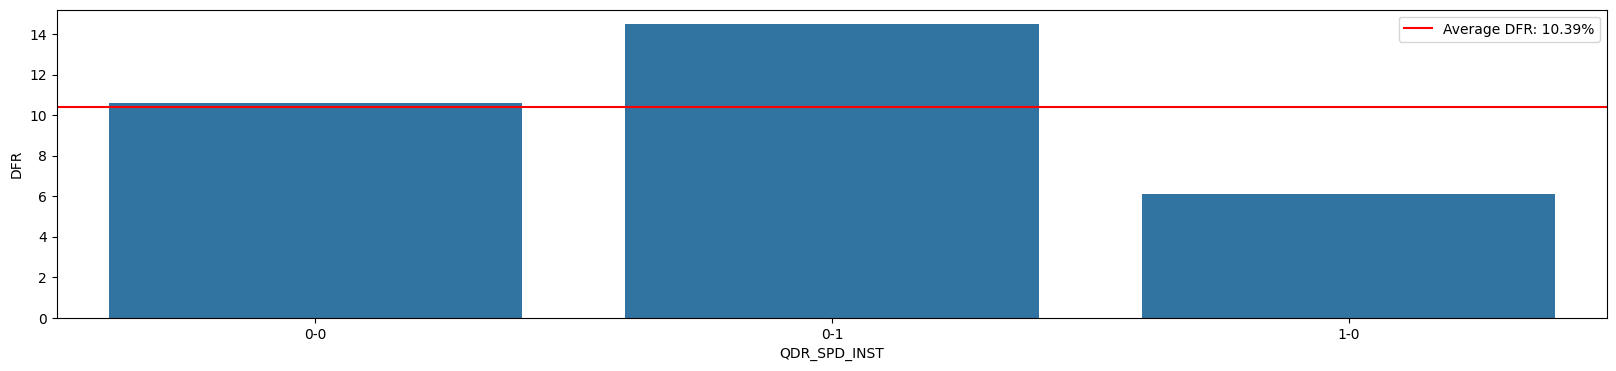

In [911]:
gccb.pctDfr('QDR_SPD_INST', groupby_flag=False)

# POS or Buy Now Pay Later

In [914]:
df_pos = pipeline.importData('pos')

In [939]:
df_pos_agg = df_pos.pivot_table(index='SK_ID_CURR', values=['CNT_INSTALMENT', 'SK_ID_PREV'], aggfunc={'CNT_INSTALMENT':'max', 'SK_ID_PREV':'nunique'}).reset_index()

In [941]:
df_pos_agg.columns = [pkey, 'MAX_INST', 'CNT_POS']

In [942]:
df_pos_agg['SCL_MAX_INST'] = scaler.fit_transform(df_pos_agg[['MAX_INST']])
df_pos_agg['SCL_CNT_POS'] = scaler.fit_transform(df_pos_agg[['CNT_POS']])

In [944]:
df_pos_agg['QDR_SCL_MAX_INST'] = df_pos_agg['SCL_MAX_INST'].apply(lambda x: 0 if x < 0 else 1).astype(int)
df_pos_agg['QDR_SCL_CNT_POS'] = df_pos_agg['SCL_CNT_POS'].apply(lambda x: 0 if x < 0 else 1).astype(int)

In [945]:
df_pos_agg['QDR_POS_INST'] = df_pos_agg.apply(lambda row: "-".join([str(row[col]) for col in ['QDR_SCL_MAX_INST', 'QDR_SCL_CNT_POS']]), axis=1)

In [949]:
df_pos_agg = df_pos_agg.merge(df_application[[pkey, tg]], on=pkey, how='inner')

In [951]:
gppi = graphVisualizer(df_pos_agg)

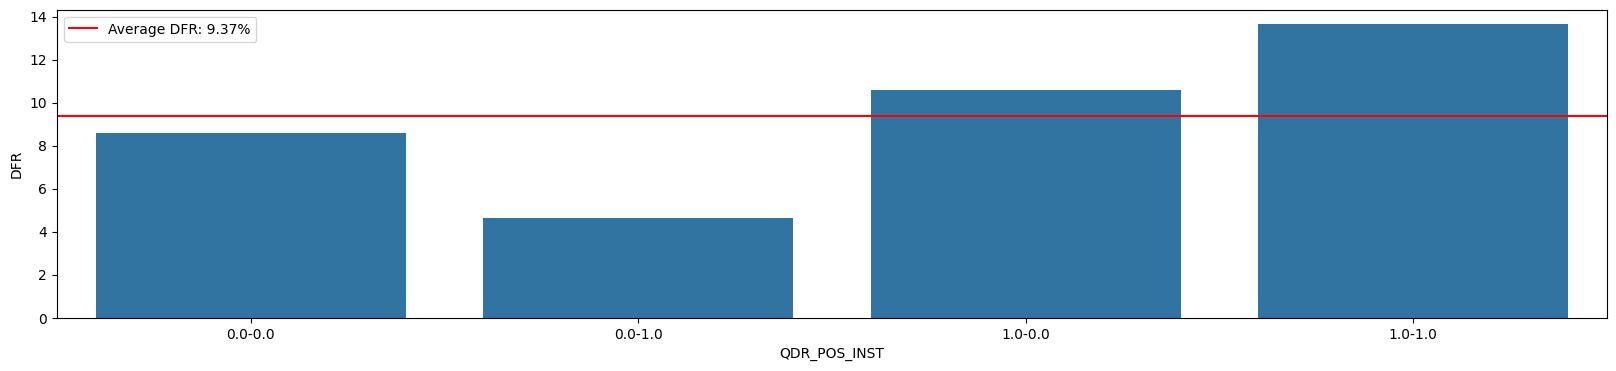

In [952]:
gppi.pctDfr('QDR_POS_INST', groupby_flag=False)

# Summary

Interesting features are the following...

Application Data
* `P_INCOME_TOTAL`
* `CODE_GENDER`
* `NAME_EDUCATION_TYPE`
* `AGE`

Social
* `DEF_30_CNT_SOCIAL_CIRCLE`
* `DEF_60_CNT_SOCIAL_CIRCLE`

Document when applying
* All field -> indicate where is it missing  `DOCUMENTS`
* `APPL_WKND_FLAG` x `OCCUPATION_TYPE`
* [FE] `CITY_REG` (choose one from region level and city level)
* `LIVE_CITY_NOT_WORK_CITY`

External
* `EXT_SOURCE_1`,	`EXT_SOURCE_2`, `EXT_SOURCE_3`

Reachability
* `FLAG_WORK_PHONE`
* `FLAG_PHONE`  --> Indicate desk type job

Identity -> Why it might matter? might correlated?
* `DAYS_REGISTRATION`
* `DAYS_ID_PUBLISH`
* `DAYS_LAST_PHONE_CHANGE`

Loan info
* `AMT_CREDIT`
* `NAME_CONTRACT_TYPE`
* [FE] `N_REPAYMENT`
* [FE] `LOAN_PLANNING`
* [FE] `HMLOAN_LOYALTY`

Track Record
* [FE] `PCT_PREV_APPR`
* [FE] `PCT_PREV_RFUS`

Bureau Record
* [FE] `DPD_EVER_FLAG`
   
Credit Card
* [FE] `CNT_OTH_CC`
* [FE] `CNT_HML_CC_ACTIVE`
* [FE] `AVG_CC_SPD`, `MIN_CC_SPD`, `MONTHS_BALANCE`
* [FE] `SD_INST_NBR`, `MED_INST_NBR`
* [FE] `QDR_SPD_INST`

POS
* [FE] `QDR_POS_INST`